# DistilBERT hierarchical multi-class classification model Creation 

In [1]:
import pandas as pd
import re
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

## Dataset Creation & Cleaning Functions 

In [2]:
# Get Dataset from FILE_PATH, use CALS as headers 
def get_dataset(FILE_PATH, COLS):
    df = pd.read_csv(FILE_PATH, names=COLS, index_col=False)
    df.head() 
    return df

In [3]:
# Clean Text function - use reges to remove non alphanumeric characters, remove common key words from data source 
def clean_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)

    # Remove specified words
    words_to_remove = ['tesco', 'tescos', 'sainsbury', 'sainsburys']
    pattern = re.compile(r'\b(' + '|'.join(words_to_remove) + r')\b', re.IGNORECASE)
    text = pattern.sub("", text)

    # Remove extra spaces
    text = ' '.join(text.split())

    return text

In [4]:
# Remove quantity based text, remove common quantaties 
def remove_quantities(text):
    # Remove quantities like '4 pack', '500g', '1kg', etc.
    pattern = r"\b\d+\s*(pack|g|kg|ml|l|oz|lb)\b"
    text_without_quantities = re.sub(pattern, "", text, flags=re.IGNORECASE)
    
    # Remove standalone numbers
    pattern = r"\b\d+\b"
    text_without_quantities = re.sub(pattern, "", text_without_quantities)
    
    return text_without_quantities

## Pre-Processing Functions

In [5]:
# Encoding Labels, returns the label dictionary 
def encode_labels(df):
    possible_labels = df.CATEGORY.unique()
    label_dict = {}
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index
    print(label_dict)
    return possible_labels, label_dict

### Train test split

In [6]:
# Train test split, edits dataframe. Randomizes data.
def tts_df(df):
    df = df.sample(frac=1, random_state=42)

    x_train, x_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.2,
        random_state=42,
        stratify=df.label.values
    )

    df['data_type'] = ['not_set']*df.shape[0]

    df.loc[x_train, 'data_type'] = 'train'
    df.loc[x_val, 'data_type'] = 'val'

    df.groupby(['CATEGORY', 'label', 'data_type']).count()

    return df, x_train, x_val, y_train, y_val

### Tokenization 

In [7]:
# Tokenizes and inputted dataframe, returns 2 TensorDatasets for training and validation
def tokenize_df(df):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',
                                            do_lower_case=True)

    encoded_data_train = tokenizer.batch_encode_plus(
        df[df.data_type=='train'].NAME.values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=512,
        return_tensors='pt',
    )


    encoded_data_val = tokenizer.batch_encode_plus(
        df[df.data_type=='val'].NAME.values, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        pad_to_max_length=True, 
        max_length=256, 
        return_tensors='pt'
    )

    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(df[df.data_type=='train'].label.values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(df[df.data_type=='val'].label.values)

    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

    return dataset_train, dataset_val



### Evaluation Metrics

In [8]:
# Performance Metrics 

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [9]:
def evaluate(dataloader_val, model, device):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    true_probs, predicted_probs = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        true_probs.append(label_ids.flatten())
        predicted_probs.append(logits)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    true_probs = np.concatenate(true_probs, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
            
    return loss_val_avg, predictions, true_vals, true_probs, predicted_probs


## Training Functions

In [10]:
def training_loop(model, epochs, dataloader_train, dataloader_validation, device, optimizer, scheduler, SAVE_PATH):
    training_stats = []
    for epoch in tqdm(range(1, epochs+1)):
        
        model.train()
        
        loss_train_total = 0
        correct_train_total = 0
        total_train_samples = 0

        progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
        for batch in progress_bar:

            model.zero_grad()
            
            batch = tuple(b.to(device) for b in batch)
            
            inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2],
                    }       

            outputs = model(**inputs)
            
            loss = outputs[0]
            logits = outputs[1]
            loss_train_total += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            # Calculate accuracy
            preds = torch.argmax(logits, dim=1)
            correct_train_total += (preds == inputs['labels']).sum().item()
            total_train_samples += inputs['labels'].size(0)
            
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
            
        torch.save(model.state_dict(), f'{SAVE_PATH}/finetuned_BERT_epoch_{epoch}.model')
            
        tqdm.write(f'\nEpoch {epoch}')
        
        loss_train_avg = loss_train_total/len(dataloader_train)            
        tqdm.write(f'Training loss: {loss_train_avg}')
        
        val_loss, predictions, true_vals, preds_flat, true_probs = evaluate(dataloader_validation, model, device)
        val_f1 = f1_score_func(predictions, true_vals)
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (Weighted): {val_f1}')
        train_accuracy = correct_train_total / total_train_samples
        training_stats.append({
            'epoch': epoch,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'Training Accur.': train_accuracy,  # You will need to calculate the training accuracy
            'Valid. Accur.': val_f1,
        })
    return training_stats

## Testing

In [11]:
def load_test(label_dict, device, dataloader_validation, SAVE_PATH):
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                        num_labels=len(label_dict),
                                                        output_attentions=False,
                                                        output_hidden_states=False)

    model.to(device)

    model.load_state_dict(torch.load(f'{SAVE_PATH}/finetuned_BERT_epoch_4.model', map_location=torch.device('cuda')))

    val_loss, predictions, true_vals, preds_flat, true_probs = evaluate(dataloader_validation, model=model, device=device)
    accuracy_per_class(predictions, true_vals, label_dict)
    return val_loss, predictions, true_vals, preds_flat, true_probs

### Data Viz Functions

In [12]:
## Confusion Matrix 
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [13]:
def plot_bar_charts(training_stats):
    df_stats = pd.DataFrame(training_stats)
    df_stats = df_stats.set_index('epoch')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    ax1.plot(df_stats['Training Loss'], label="Training Loss")
    ax1.plot(df_stats['Valid. Loss'], label="Validation Loss")
    ax1.set_title("Loss Curve")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(df_stats['Training Accur.'], label="Training Accuracy")
    ax2.plot(df_stats['Valid. Accur.'], label="Validation Accuracy")
    ax2.set_title("Accuracy Curve")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.show()


In [14]:

def plot_roc_auc(y_true, y_pred, true_probs, predicted_probs, label_names):
    n_classes = len(label_names)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_probs[:, i], predicted_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label_names[i]} (area = {roc_auc[i]:.2f}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


## Training 

In [15]:
## Full training Loop
from scipy.special import softmax


def model_trainer(DATA_SET_PATH, SAVE_PATH, COLS, BATCH_SIZE, EPOCHS, MODEL_NAME, DROPOUT_RATE, LEARNING_RATE, WEIGHT_DECAY, GRADIENT_CLIPPING):
    # Get Dataset
    print(f'Opening Dataset of Model: {MODEL_NAME}')
    df = get_dataset(DATA_SET_PATH, COLS)
    
    # Clean Dataset
    print(f'Cleaning Dataset of Model: {MODEL_NAME}')
    df['NAME'] = df['NAME'].apply(clean_text)
    df['NAME'] = df['NAME'].apply(remove_quantities)
    df['NAME'] = df['NAME'].str.replace('\d', '', regex=True)

    # Encoding labels
    print(f'Encoding Labels of Model: {MODEL_NAME}')
    possible_labels, label_dict = encode_labels(df)
    df['label'] = df.CATEGORY.replace(label_dict)

    # Train Test split
    print(f'Splitting Data of Model: {MODEL_NAME}')
    df, x_train, x_val, y_train, y_val = tts_df(df)

    # Tokenization 
    print(f'Tokenizing: {MODEL_NAME}')
    dataset_train, dataset_val = tokenize_df(df)

    # Create Model from pre-made bert 
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                        num_labels=len(label_dict),
                                                        output_attentions=False,
                                                        output_hidden_states=False
                                                        )
    
    ## Loading data 
    print(f'Loading Data of Model: {MODEL_NAME}')
    dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=BATCH_SIZE)

    dataloader_validation = DataLoader(dataset_val, 
                                    sampler=SequentialSampler(dataset_val), 
                                    batch_size=BATCH_SIZE)
    
    ## Optimizer & Schedular 
    optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE, 
                  eps=1e-8,
                  weight_decay=WEIGHT_DECAY,
                  )

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=0,
                                                num_training_steps=len(dataloader_train)*EPOCHS)

    ## Cuda Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model.to(device)
    torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING)
    seed_val = 17
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    print(f'Training of Model: {MODEL_NAME}')
    training_stats = training_loop(epochs=EPOCHS, dataloader_train=dataloader_train,
                  dataloader_validation=dataloader_validation,
                  device=device, optimizer=optimizer,
                  scheduler=scheduler, SAVE_PATH=SAVE_PATH,
                  model=model
                  )
    
    print(f'Testing Model: {MODEL_NAME}')
    val_loss, predictions, true_vals, y_true, y_pred = load_test(label_dict=label_dict,
              device=device,
              dataloader_validation=dataloader_validation,
              SAVE_PATH=SAVE_PATH
              )
    y_pred_labels = np.argmax(y_pred, axis=1)

    plot_confusion_matrix(y_true, y_pred_labels, list(label_dict.keys()))
    plot_bar_charts(training_stats)
    
    y_true_probs = np.eye(len(label_dict))[y_true]
    y_pred_probs = softmax(predictions, axis=1)
    
    plot_roc_auc(y_true, y_pred, y_true_probs, y_pred_probs, list(label_dict.keys()))

Opening Dataset of Model: Food And Beverage Classifier
Cleaning Dataset of Model: Food And Beverage Classifier
Encoding Labels of Model: Food And Beverage Classifier
{'FDAA': 0, 'BEVA': 1}
Splitting Data of Model: Food And Beverage Classifier
Tokenizing: Food And Beverage Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing Dist

Loading Data of Model: Food And Beverage Classifier
Using device: cuda
Training of Model: Food And Beverage Classifier


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.21145909213867664
Validation loss: 0.14607035315095665
F1 Score (Weighted): 0.9702795309839212


Epoch 2:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0630475879791371
Validation loss: 0.13160449493375115
F1 Score (Weighted): 0.9781278485525492


Epoch 3:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.017259102762230232
Validation loss: 0.14217814993843442
F1 Score (Weighted): 0.9782049893882087


Epoch 4:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.004270249274704624
Validation loss: 0.15058556335925993
F1 Score (Weighted): 0.9802207172166361


Epoch 5:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0002396093341906398
Validation loss: 0.15458694119263194
F1 Score (Weighted): 0.9802207172166361
Testing Model: Food And Beverage Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: FDAA
Accuracy: 396/399

Class: BEVA
Accuracy: 103/110



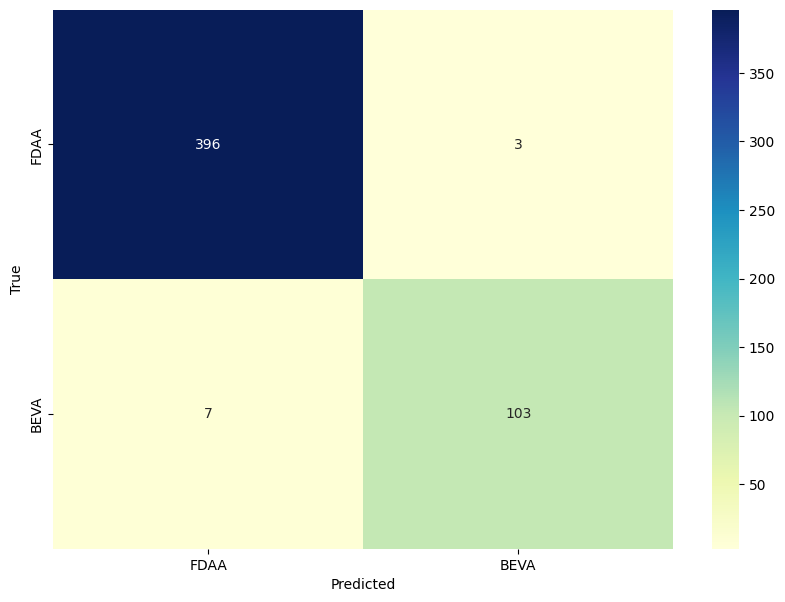

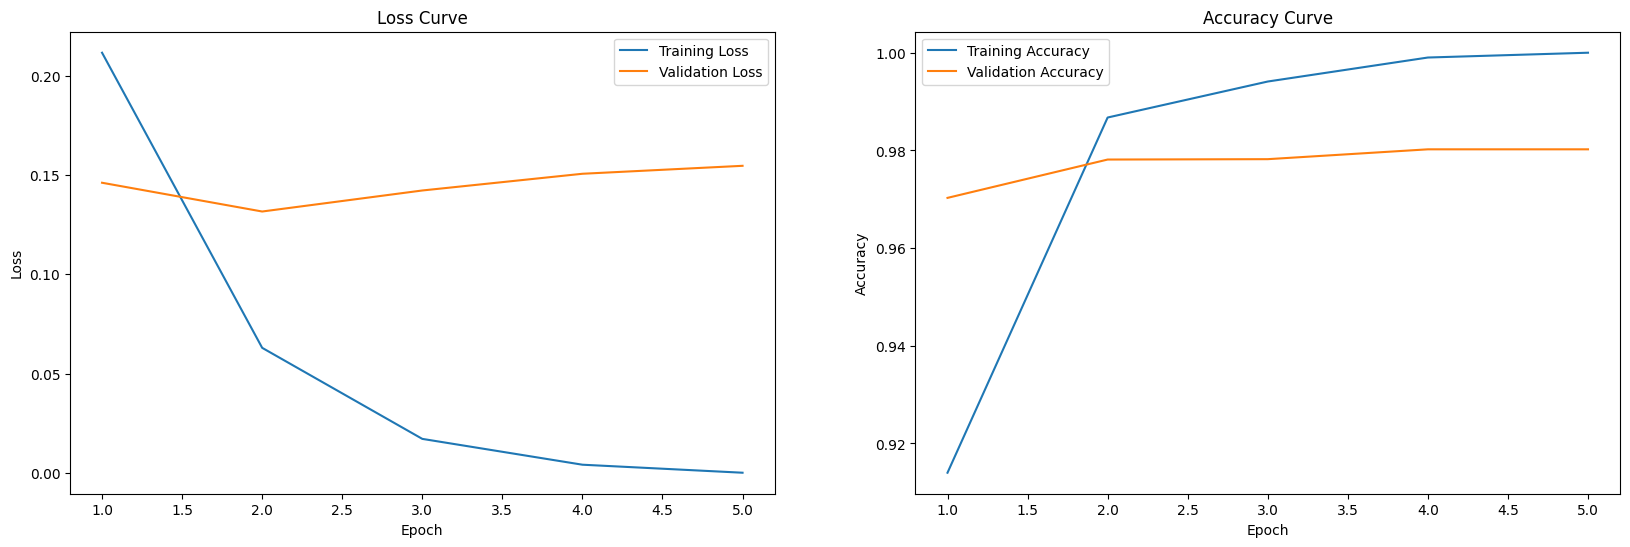

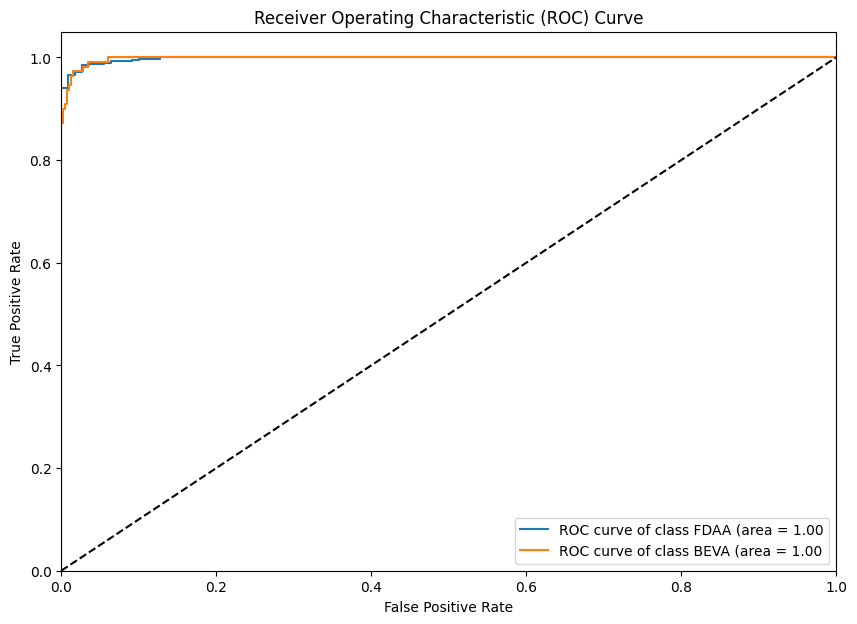

Opening Dataset of Model: FDAA Classifier
Cleaning Dataset of Model: FDAA Classifier
Encoding Labels of Model: FDAA Classifier
{'BAKA': 0, 'MISC': 1, 'ANIP': 2, 'FRTV': 3, 'CUFD': 4}
Splitting Data of Model: FDAA Classifier
Tokenizing: FDAA Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing Dist

Loading Data of Model: FDAA Classifier
Using device: cuda
Training of Model: FDAA Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/531 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9548141069275287
Validation loss: 0.2437122524120754
F1 Score (Weighted): 0.9422434177683884


Epoch 2:   0%|          | 0/531 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.15865842785893214
Validation loss: 0.2034770266145916
F1 Score (Weighted): 0.9545601630150212


Epoch 3:   0%|          | 0/531 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.08043031780778828
Validation loss: 0.15496489092798665
F1 Score (Weighted): 0.9620777241960715


Epoch 4:   0%|          | 0/531 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.03360585594640101
Validation loss: 0.17729785498599276
F1 Score (Weighted): 0.9670721329157674


Epoch 5:   0%|          | 0/531 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0235388335684602
Validation loss: 0.15397620314112478
F1 Score (Weighted): 0.9696329060747313
Testing Model: FDAA Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: BAKA
Accuracy: 72/75

Class: MISC
Accuracy: 74/83

Class: ANIP
Accuracy: 88/88

Class: FRTV
Accuracy: 73/73

Class: CUFD
Accuracy: 79/80



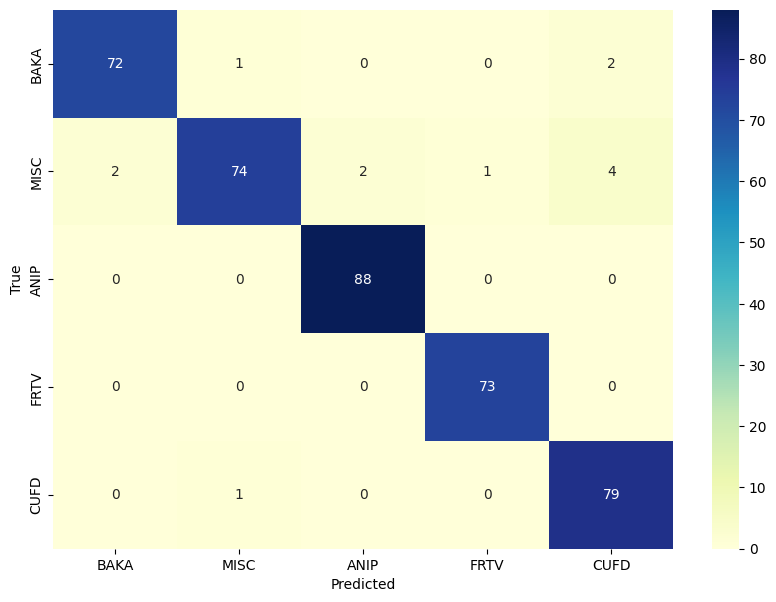

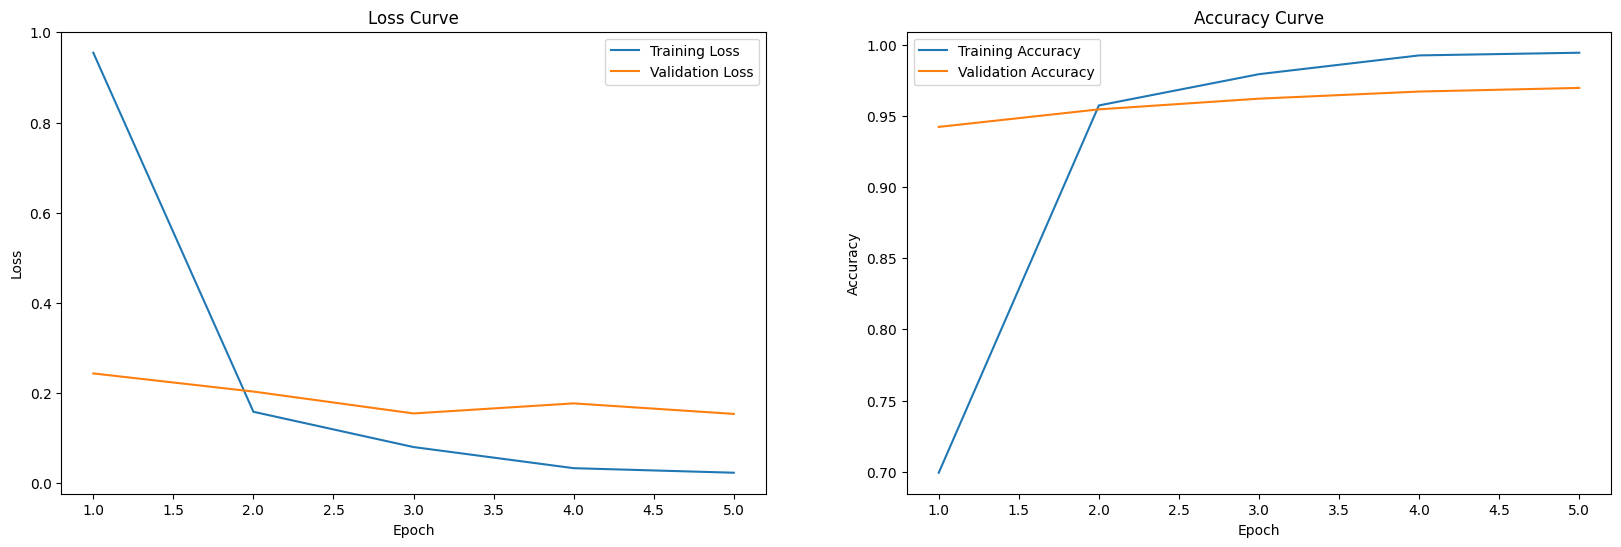

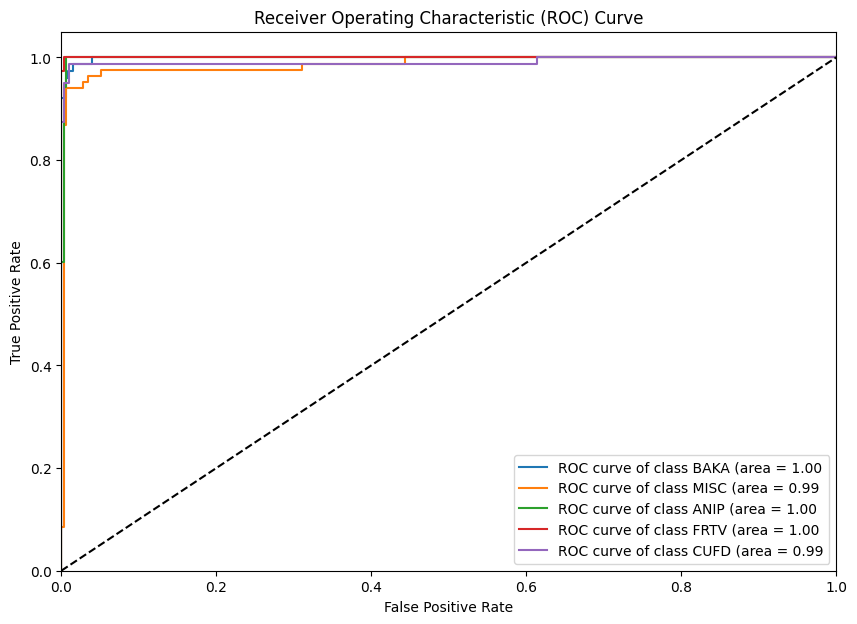

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: BEVA Classifier
Cleaning Dataset of Model: BEVA Classifier
Encoding Labels of Model: BEVA Classifier
{'SODR': 0, 'WATR': 1, 'CTCC': 2}
Splitting Data of Model: BEVA Classifier
Tokenizing: BEVA Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: BEVA Classifier
Using device: cuda
Training of Model: BEVA Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/147 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7547732124320504
Validation loss: 0.31607434213966934
F1 Score (Weighted): 0.9168052668052669


Epoch 2:   0%|          | 0/147 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.1796054267863027
Validation loss: 0.23111709446419734
F1 Score (Weighted): 0.9362513971209624


Epoch 3:   0%|          | 0/147 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.11913141306983877
Validation loss: 0.19217912334243994
F1 Score (Weighted): 0.9549526691119611


Epoch 4:   0%|          | 0/147 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.06797775619530252
Validation loss: 0.16593841038568802
F1 Score (Weighted): 0.9638274638274639


Epoch 5:   0%|          | 0/147 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.047066155751394174
Validation loss: 0.1665087748646132
F1 Score (Weighted): 0.9638274638274639
Testing Model: BEVA Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: SODR
Accuracy: 54/56

Class: WATR
Accuracy: 21/23

Class: CTCC
Accuracy: 32/32



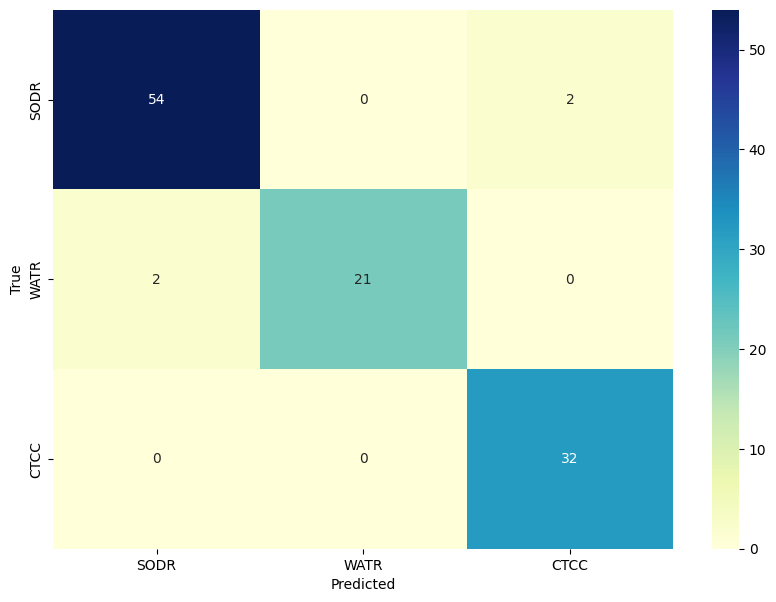

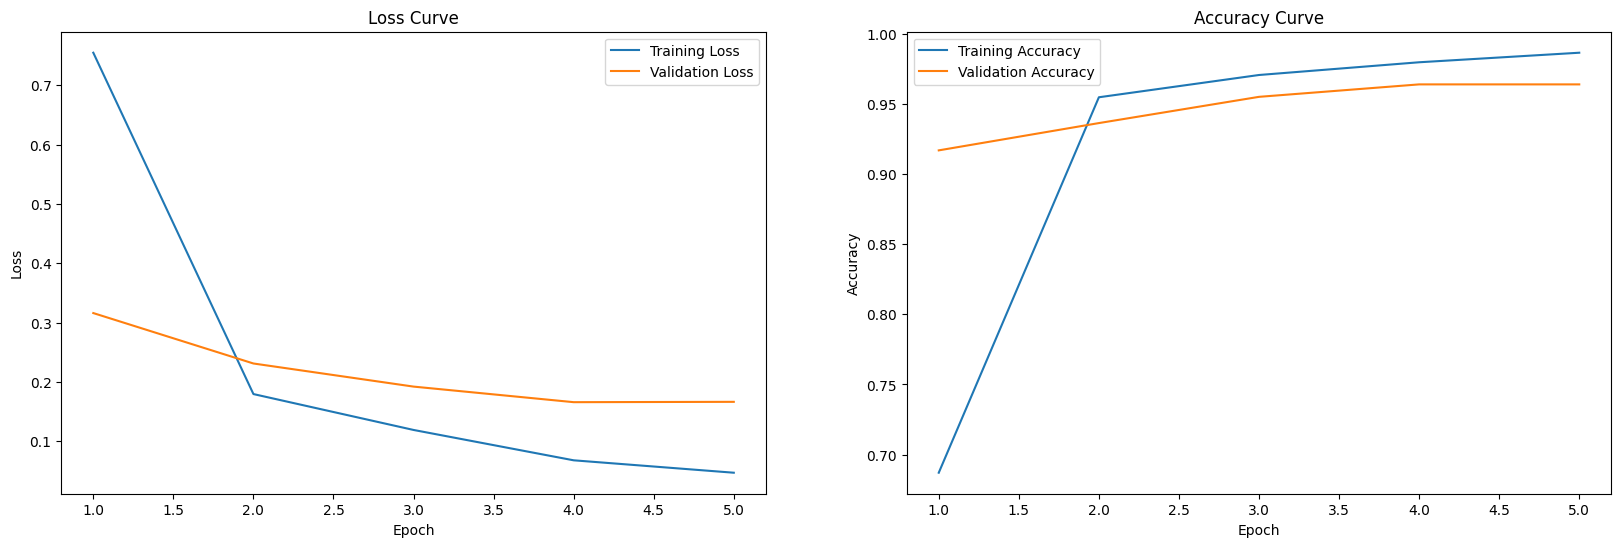

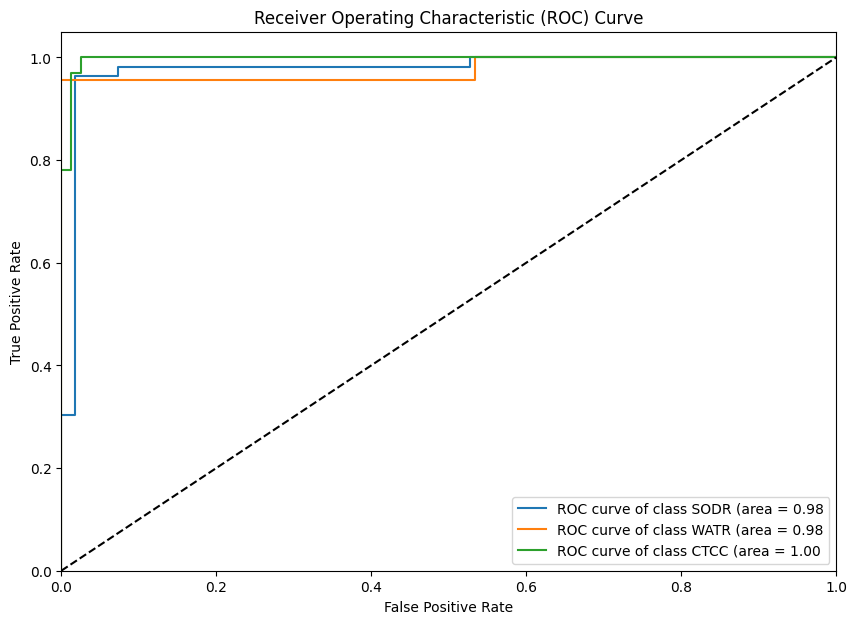

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: SODR Classifier
Cleaning Dataset of Model: SODR Classifier
Encoding Labels of Model: SODR Classifier
{'FIZD': 0, 'ENRD': 1, 'FRUJ': 2}
Splitting Data of Model: SODR Classifier
Tokenizing: SODR Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: SODR Classifier
Using device: cuda
Training of Model: SODR Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.031770299275716
Validation loss: 0.8998346705185739
F1 Score (Weighted): 0.5277777777777778


Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7298691475391388
Validation loss: 0.6313784271478653
F1 Score (Weighted): 0.6360796887112677


Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.47385324120521544
Validation loss: 0.5212901877729517
F1 Score (Weighted): 0.7650266015916986


Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.38993406295776367
Validation loss: 0.513045915451489
F1 Score (Weighted): 0.8053918580234369


Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.32172107060750327
Validation loss: 0.48718232485024554
F1 Score (Weighted): 0.8284495021337127
Testing Model: SODR Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: FIZD
Accuracy: 24/26

Class: ENRD
Accuracy: 6/14

Class: FRUJ
Accuracy: 17/17



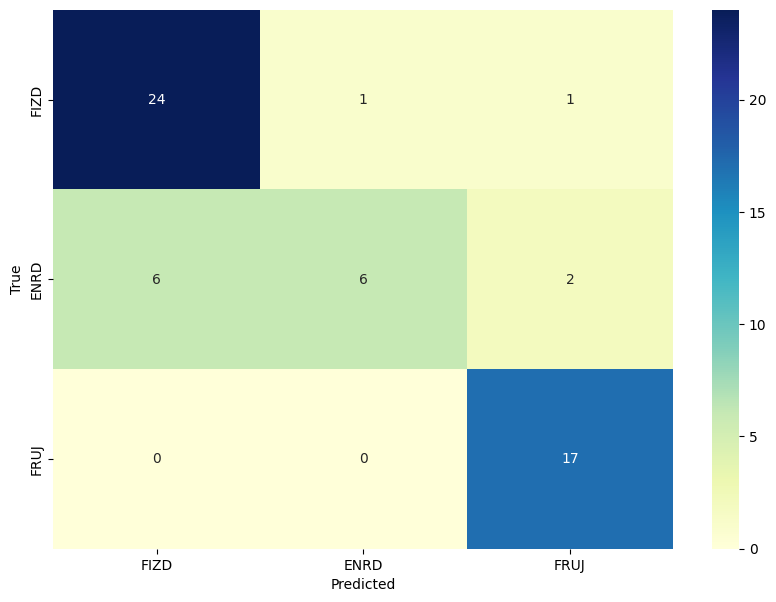

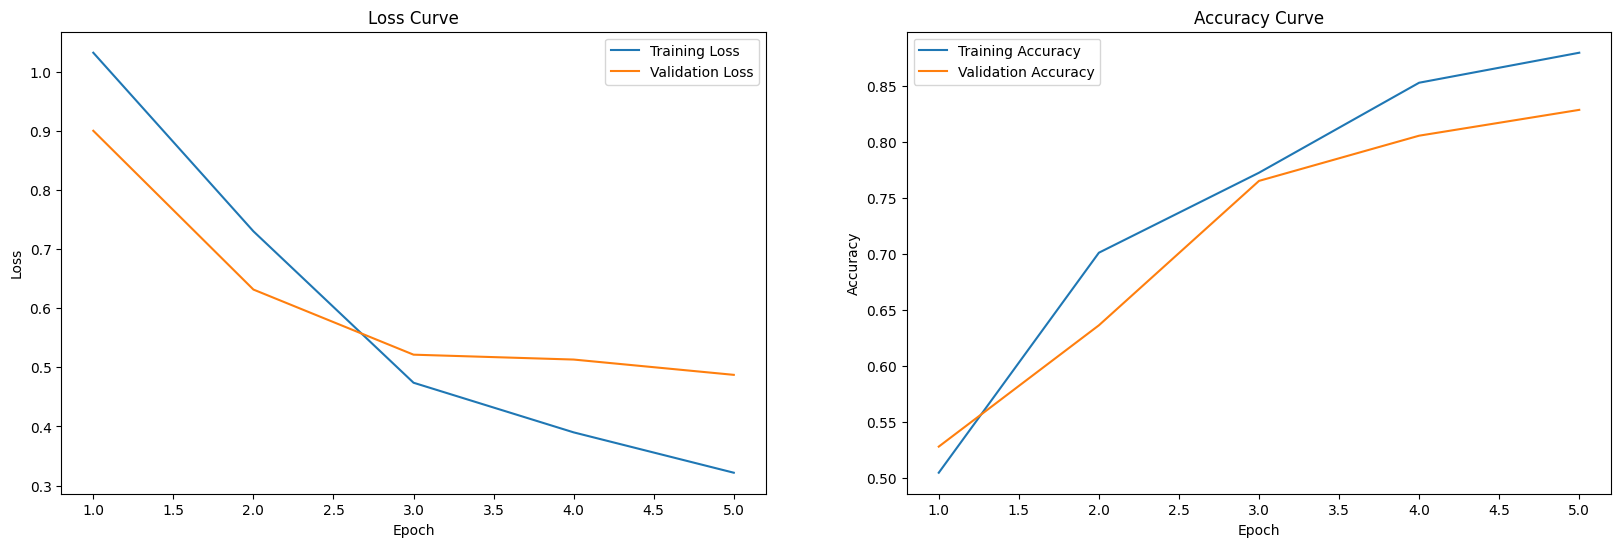

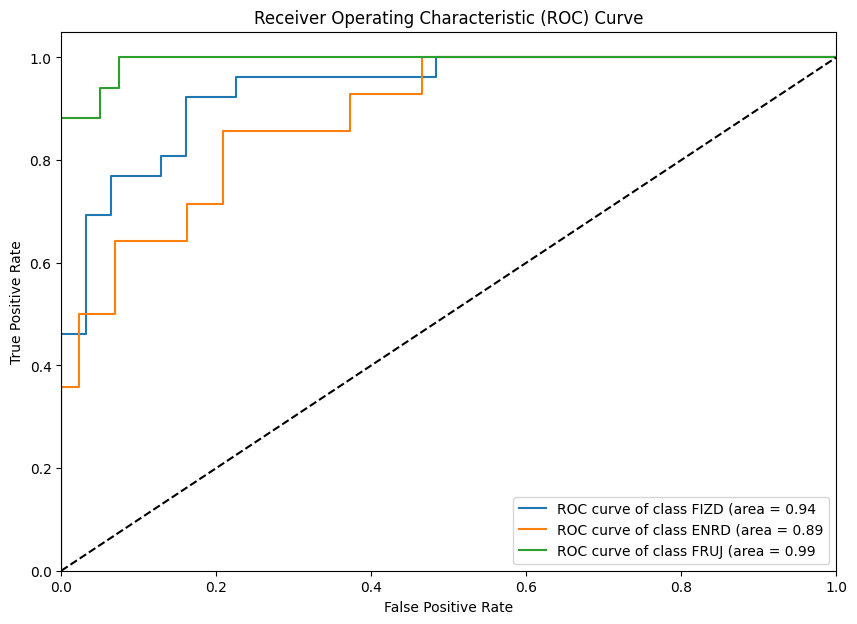

Opening Dataset of Model: WATR Classifier
Cleaning Dataset of Model: WATR Classifier
Encoding Labels of Model: WATR Classifier
{'FLWR': 0, 'SMWR': 1}
Splitting Data of Model: WATR Classifier
Tokenizing: WATR Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing Dist

Loading Data of Model: WATR Classifier
Using device: cuda
Training of Model: WATR Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5796390310410531
Validation loss: 0.42127228528261185
F1 Score (Weighted): 0.9557737260402057


Epoch 2:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3588461041931183
Validation loss: 0.24596257600933313
F1 Score (Weighted): 1.0


Epoch 3:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.24508159331256343
Validation loss: 0.1465392643585801
F1 Score (Weighted): 1.0


Epoch 4:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.15619540322692163
Validation loss: 0.0902794967405498
F1 Score (Weighted): 1.0


Epoch 5:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.11743021389890101
Validation loss: 0.07193435844965279
F1 Score (Weighted): 1.0
Testing Model: WATR Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: FLWR
Accuracy: 15/15

Class: SMWR
Accuracy: 8/8



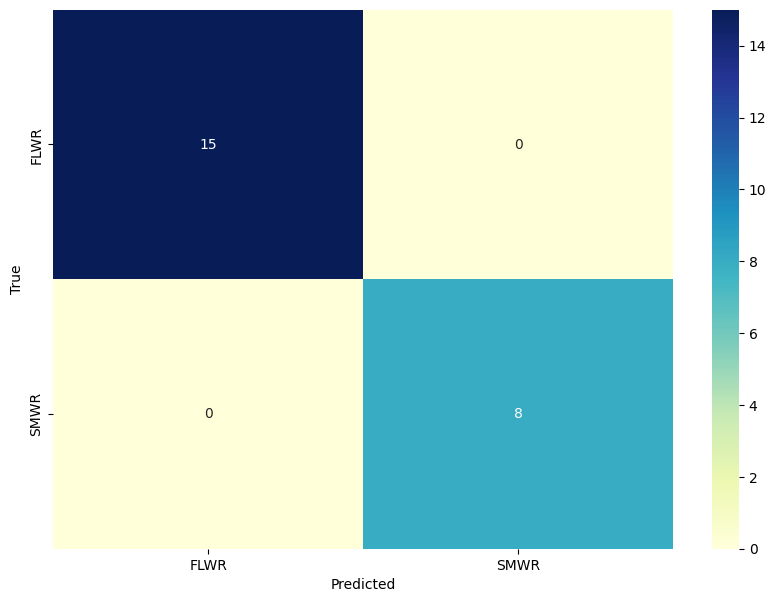

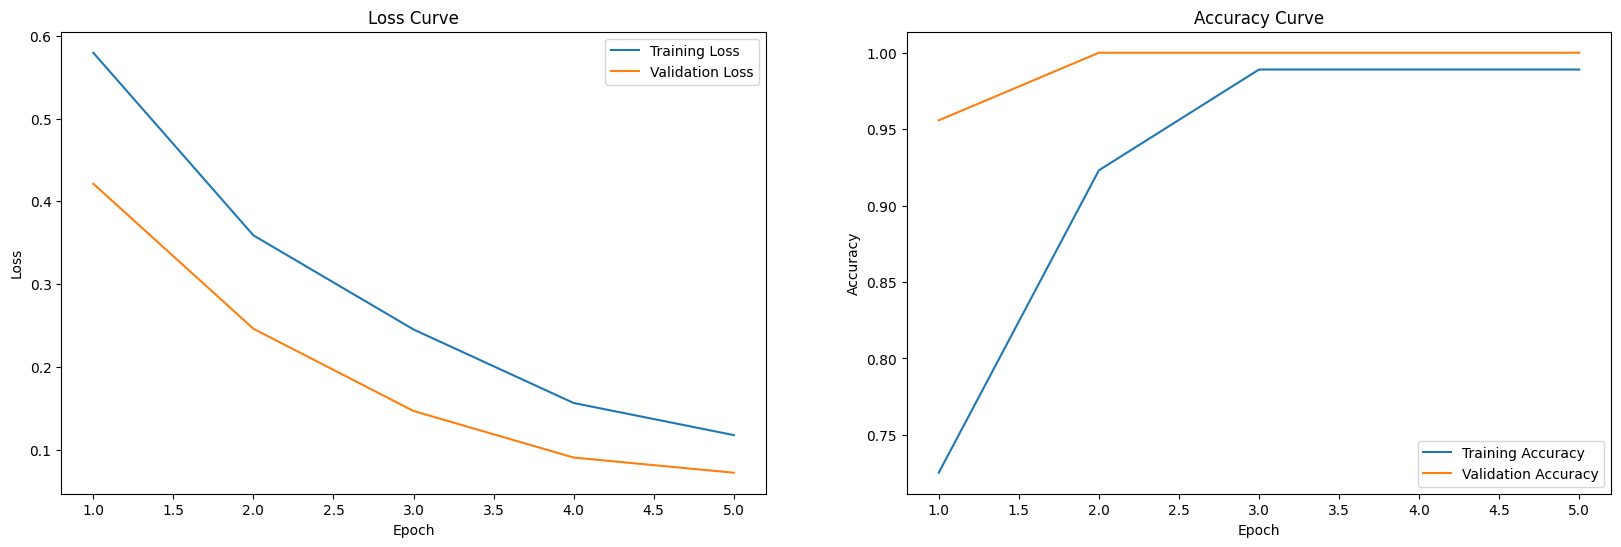

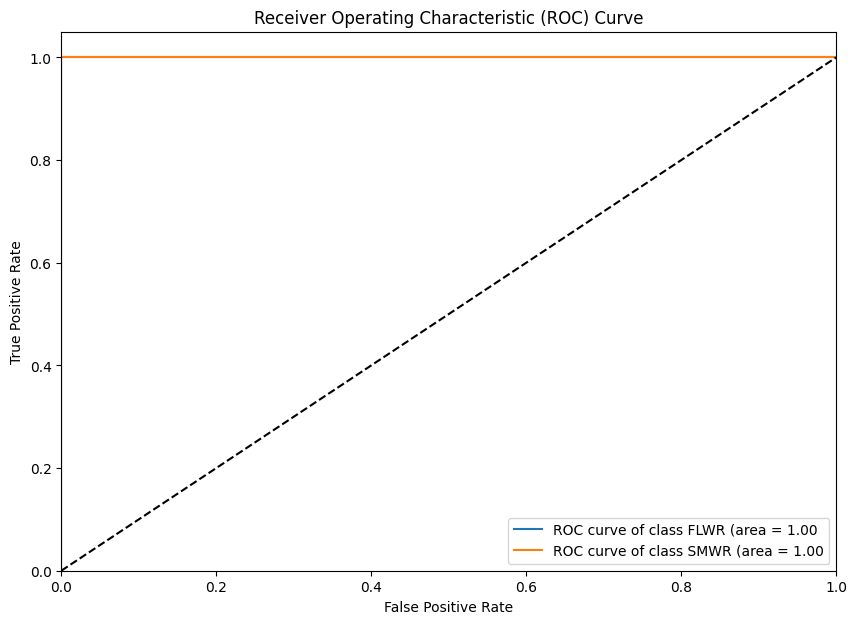

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: CTCC Classifier
Cleaning Dataset of Model: CTCC Classifier
Encoding Labels of Model: CTCC Classifier
{'COFF': 0, 'HTCD': 1, 'SBTB': 2}
Splitting Data of Model: CTCC Classifier
Tokenizing: CTCC Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: CTCC Classifier
Using device: cuda
Training of Model: CTCC Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0465872443857647
Validation loss: 0.9097681262276389
F1 Score (Weighted): 0.8468205337690631


Epoch 2:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7054907026745024
Validation loss: 0.4711134840141643
F1 Score (Weighted): 0.9686069794050344


Epoch 3:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.37726598729689914
Validation loss: 0.24910164963115344
F1 Score (Weighted): 1.0


Epoch 4:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2241806033111754
Validation loss: 0.1677281619472937
F1 Score (Weighted): 0.96875


Epoch 5:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.17565496194930302
Validation loss: 0.15027493848042053
F1 Score (Weighted): 0.96875
Testing Model: CTCC Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: COFF
Accuracy: 11/11

Class: HTCD
Accuracy: 10/10

Class: SBTB
Accuracy: 10/11



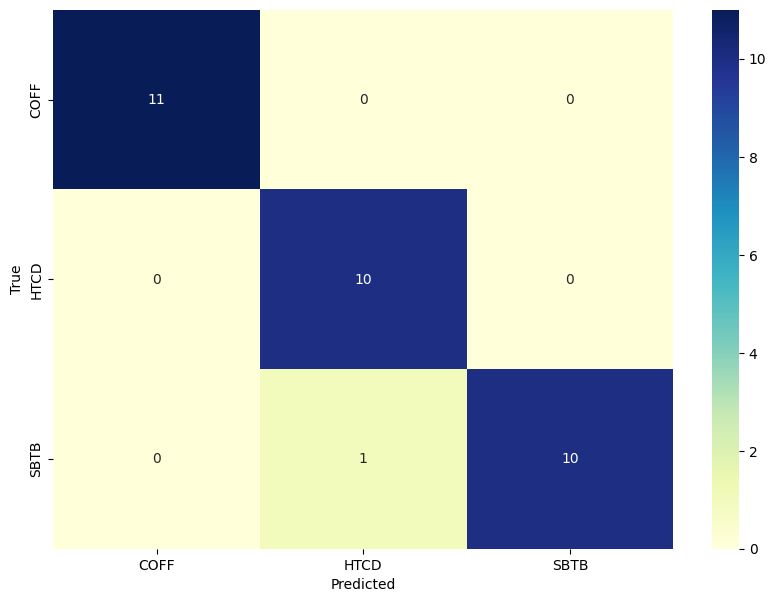

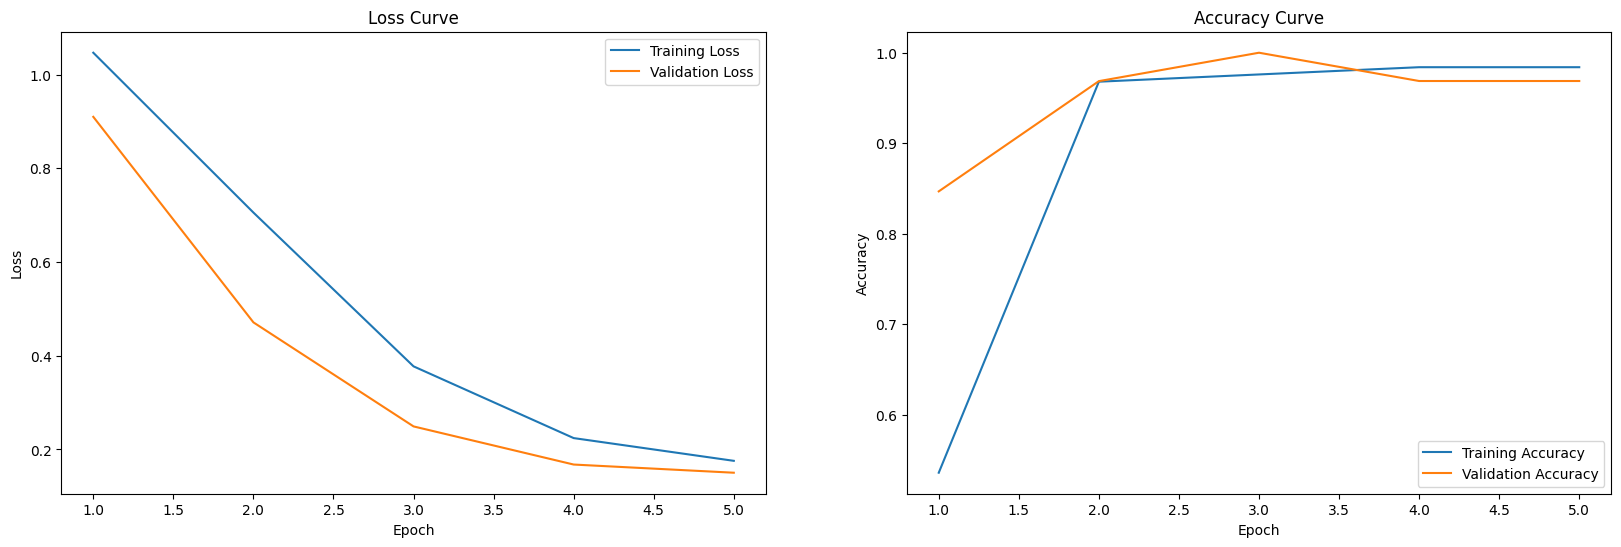

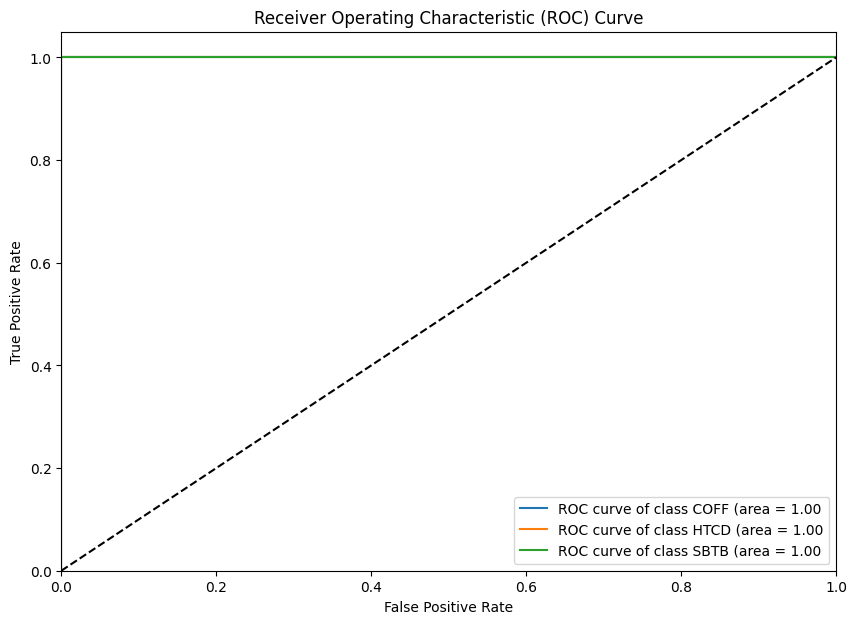

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: BAKA Classifier
Cleaning Dataset of Model: BAKA Classifier
Encoding Labels of Model: BAKA Classifier
{'BAKY': 0, 'BKGD': 1}
Splitting Data of Model: BAKA Classifier
Tokenizing: BAKA Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: BAKA Classifier
Using device: cuda
Training of Model: BAKA Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5153392567345412
Validation loss: 0.23814010978318179
F1 Score (Weighted): 0.9320926927911679


Epoch 2:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.1377377607859671
Validation loss: 0.1728116202239807
F1 Score (Weighted): 0.9598304271316591


Epoch 3:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0632566397520944
Validation loss: 0.18329353087868255
F1 Score (Weighted): 0.9598304271316591


Epoch 4:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.022894439584861447
Validation loss: 0.19874052903973138
F1 Score (Weighted): 0.9598304271316591


Epoch 5:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.019019772370096923
Validation loss: 0.19516052216148147
F1 Score (Weighted): 0.9467780026990553
Testing Model: BAKA Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: BAKY
Accuracy: 51/51

Class: BKGD
Accuracy: 22/25



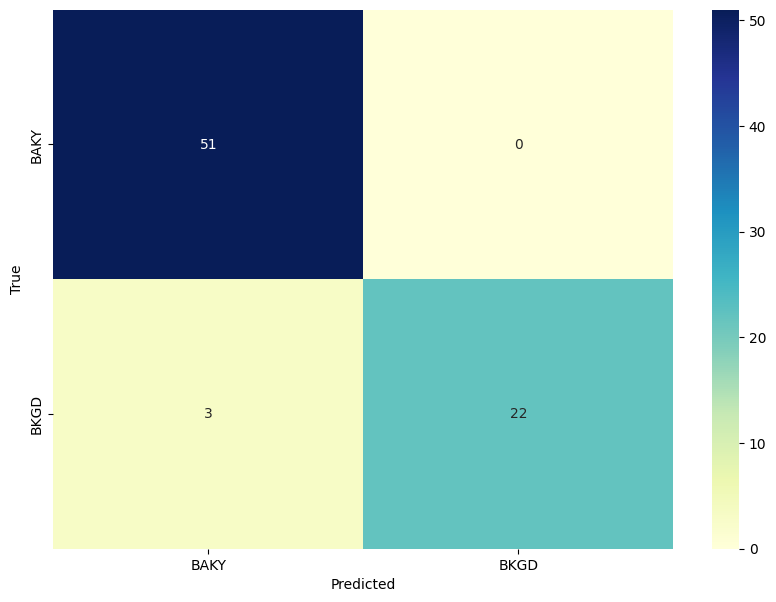

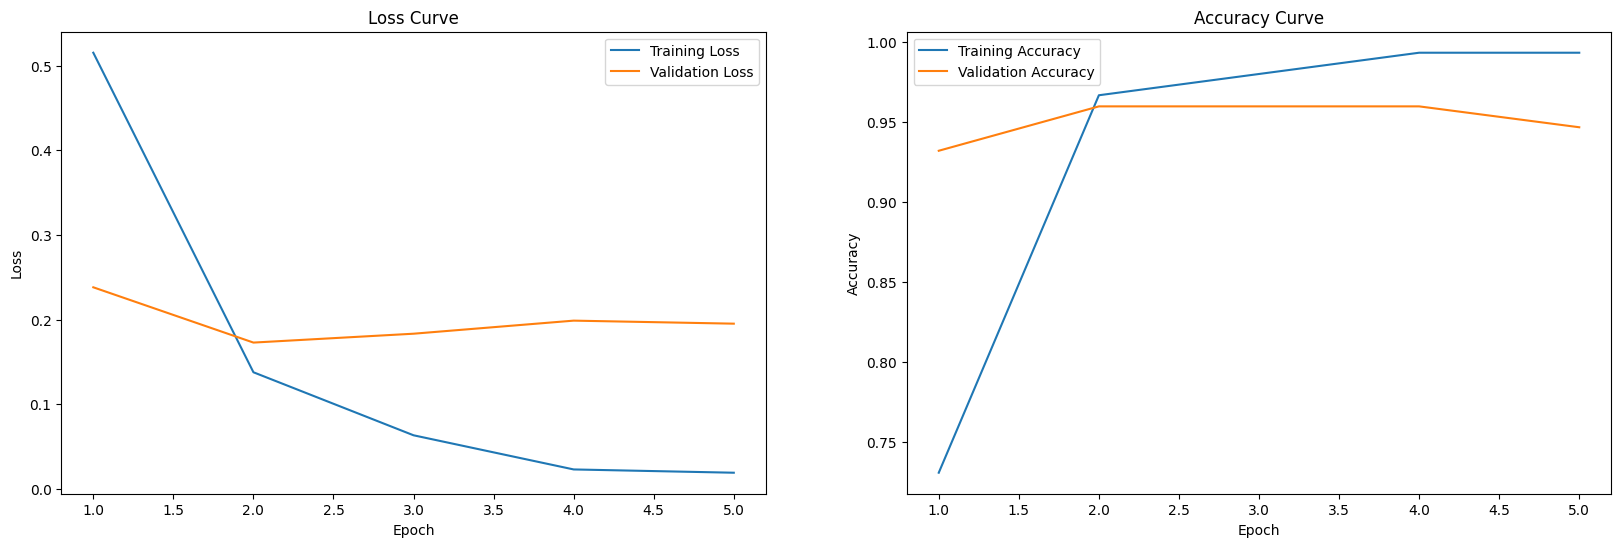

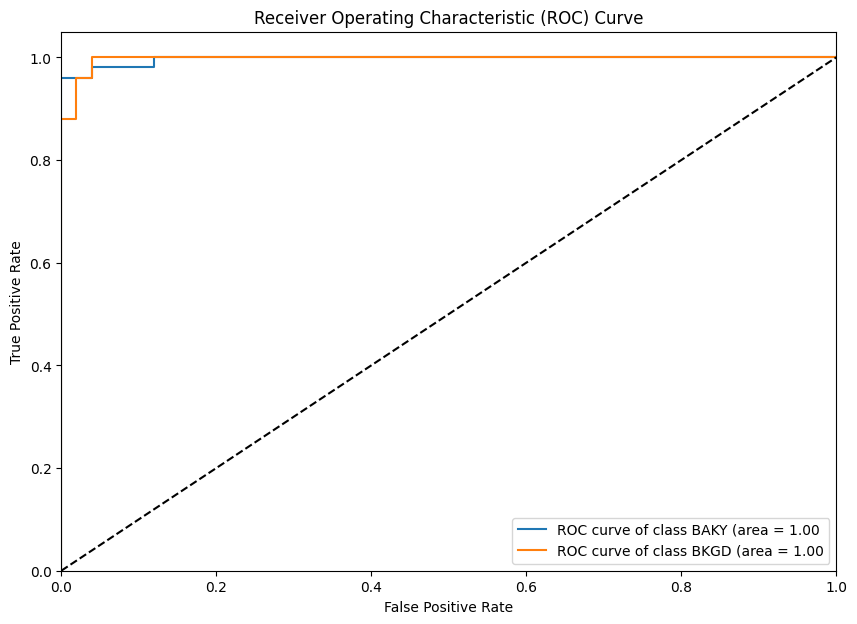

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: MISC Classifier
Cleaning Dataset of Model: MISC Classifier
Encoding Labels of Model: MISC Classifier
{'CHSW': 0, 'JAMH': 1, 'SAUC': 2}
Splitting Data of Model: MISC Classifier
Tokenizing: MISC Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: MISC Classifier
Using device: cuda
Training of Model: MISC Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9256379668777054
Validation loss: 0.6048728749155998
F1 Score (Weighted): 0.7683531746031746


Epoch 2:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3565171227396072
Validation loss: 0.24494270035730942
F1 Score (Weighted): 0.9159663865546218


Epoch 3:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.10829592162223013
Validation loss: 0.1780434642984931
F1 Score (Weighted): 0.9399336034730491


Epoch 4:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.07168230821319797
Validation loss: 0.17169369720587774
F1 Score (Weighted): 0.9521648514185829


Epoch 5:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.05382774028557915
Validation loss: 0.18925022942546224
F1 Score (Weighted): 0.9405363155363156
Testing Model: MISC Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: CHSW
Accuracy: 32/33

Class: JAMH
Accuracy: 31/32

Class: SAUC
Accuracy: 17/19



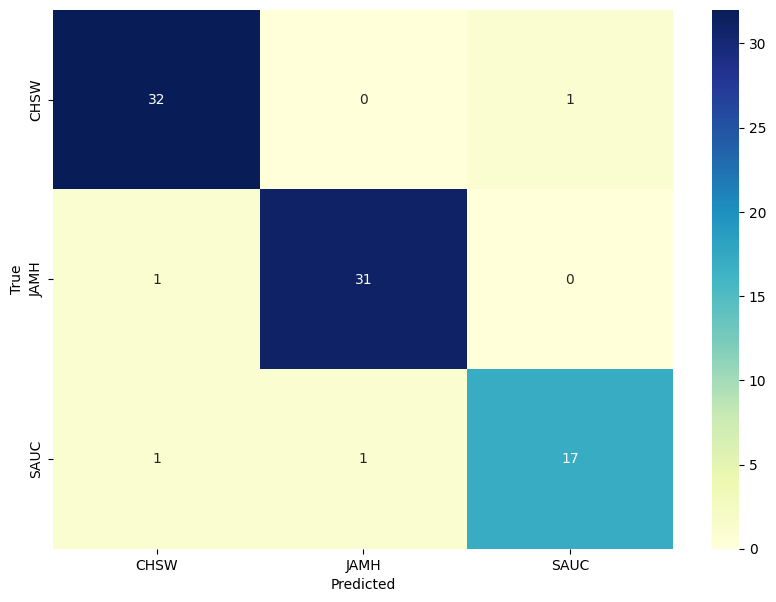

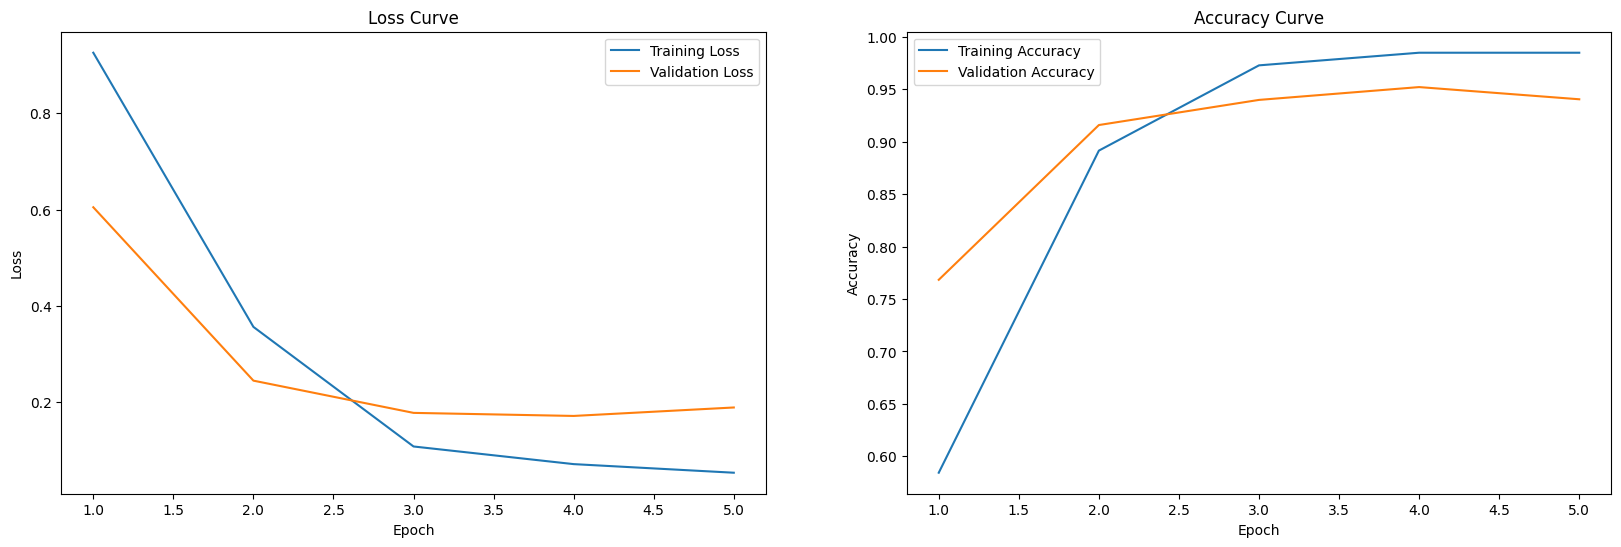

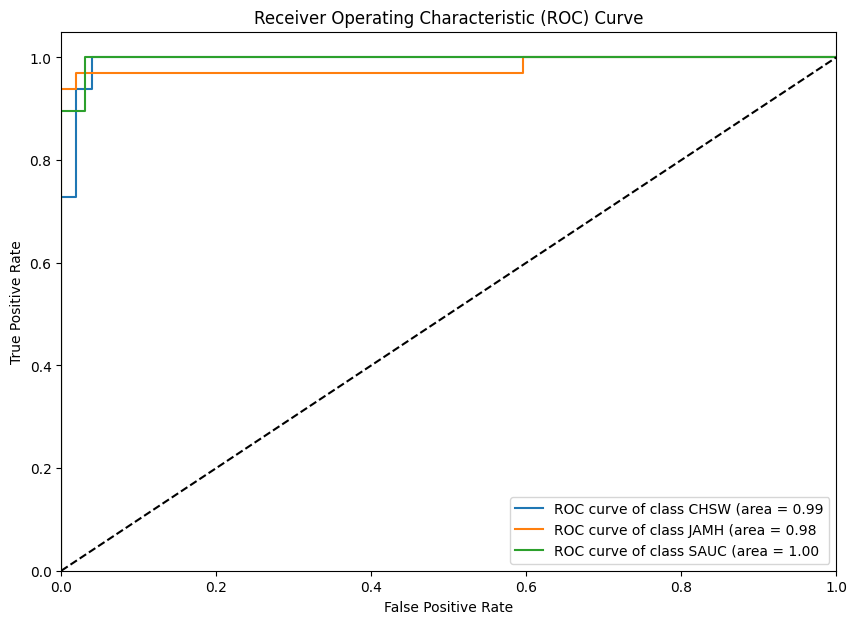

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: ANIP Classifier
Cleaning Dataset of Model: ANIP Classifier
Encoding Labels of Model: ANIP Classifier
{'DAIR': 0, 'FISH': 1, 'MEAT': 2}
Splitting Data of Model: ANIP Classifier
Tokenizing: ANIP Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: ANIP Classifier
Using device: cuda
Training of Model: ANIP Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7848488916443963
Validation loss: 0.31780853817860283
F1 Score (Weighted): 0.9767600820232399


Epoch 2:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.17732909514417505
Validation loss: 0.07074788765360912
F1 Score (Weighted): 0.9885161964472308


Epoch 3:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0676829540130929
Validation loss: 0.05369934197515249
F1 Score (Weighted): 0.9885161964472308


Epoch 4:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.06495738478823222
Validation loss: 0.04716125028207898
F1 Score (Weighted): 0.9885161964472308


Epoch 5:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.060312126747244954
Validation loss: 0.04613462037717302
F1 Score (Weighted): 0.9885161964472308
Testing Model: ANIP Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: DAIR
Accuracy: 36/36

Class: FISH
Accuracy: 14/15

Class: MEAT
Accuracy: 37/37



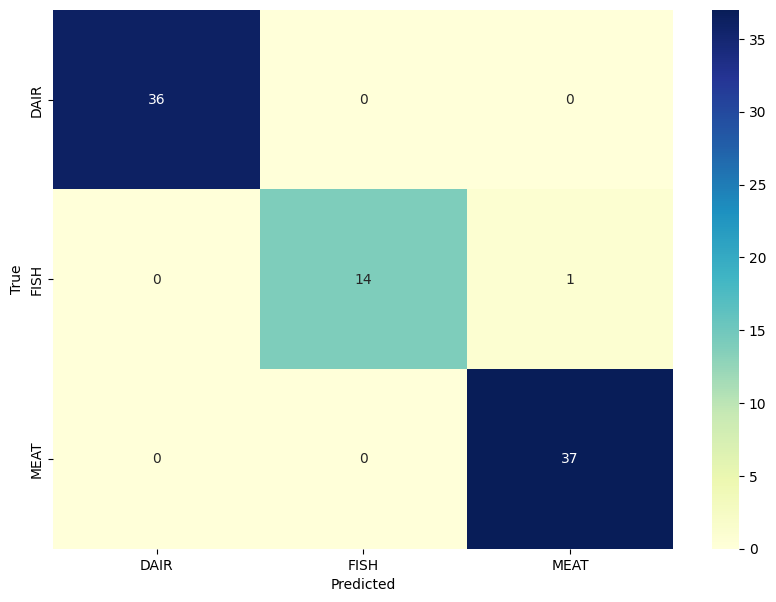

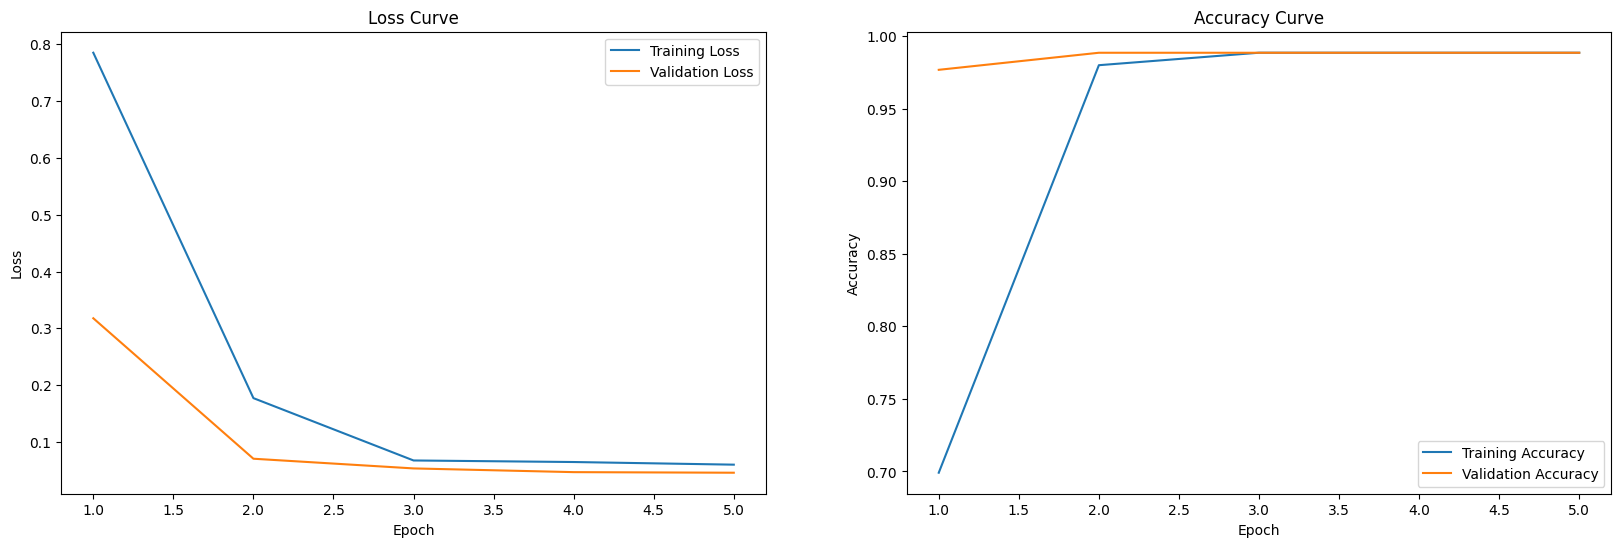

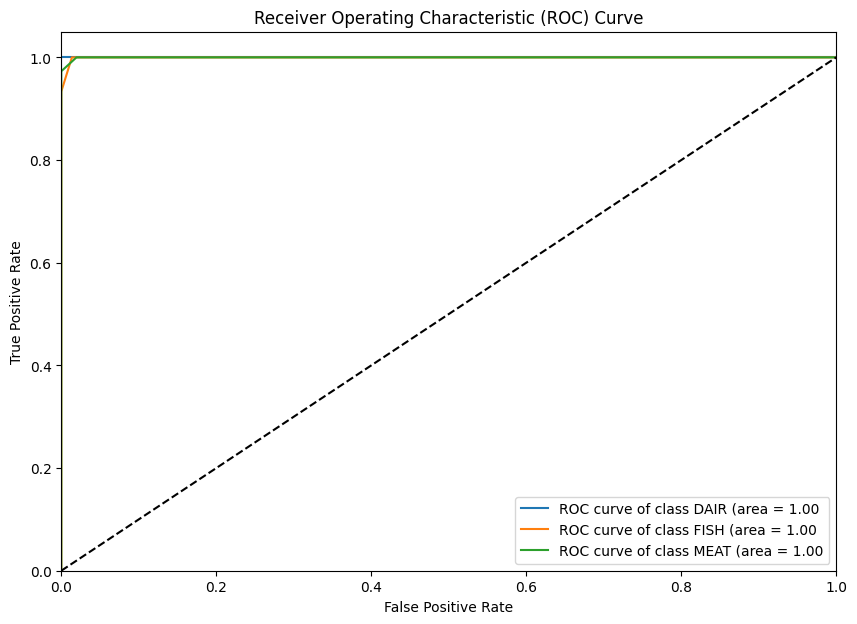

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: FRTV Classifier
Cleaning Dataset of Model: FRTV Classifier
Encoding Labels of Model: FRTV Classifier
{'FRFR': 0, 'FRVG': 1, 'POTA': 2}
Splitting Data of Model: FRTV Classifier
Tokenizing: FRTV Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: FRTV Classifier
Using device: cuda
Training of Model: FRTV Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.8663041520978987
Validation loss: 0.6427340149879456
F1 Score (Weighted): 0.5788941154120947


Epoch 2:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.387140133715782
Validation loss: 0.23388444229960442
F1 Score (Weighted): 0.9048978564425956


Epoch 3:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.10925153955894033
Validation loss: 0.09165050070732832
F1 Score (Weighted): 0.9723265464740254


Epoch 4:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.05110815525554197
Validation loss: 0.05566196151077747
F1 Score (Weighted): 0.9723265464740254


Epoch 5:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0308813095841672
Validation loss: 0.05309509679675102
F1 Score (Weighted): 0.9723265464740254
Testing Model: FRTV Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: FRFR
Accuracy: 23/24

Class: FRVG
Accuracy: 41/41

Class: POTA
Accuracy: 7/8



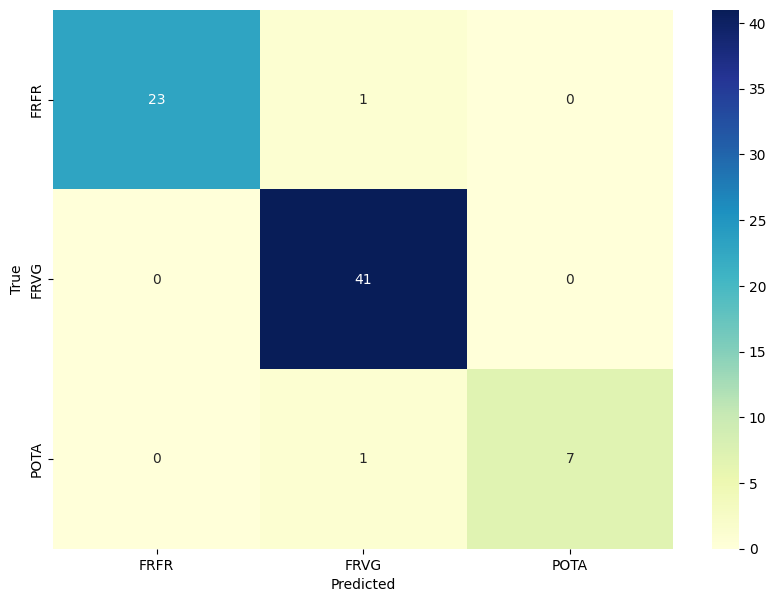

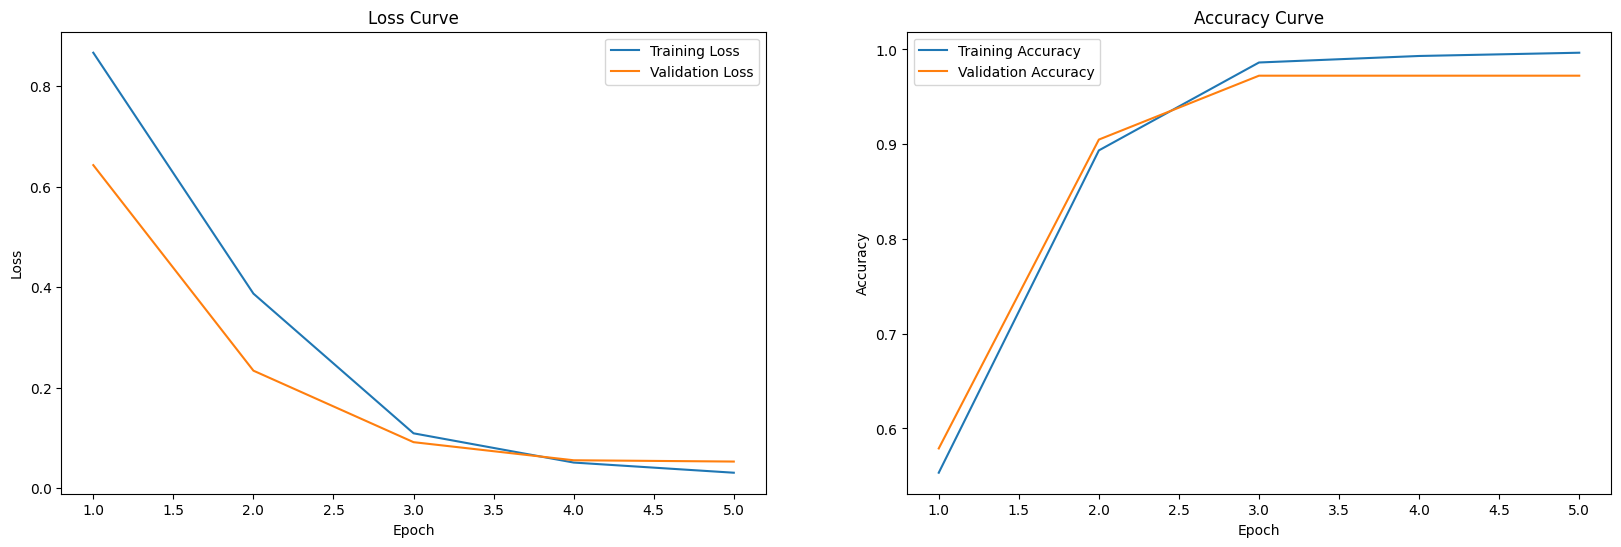

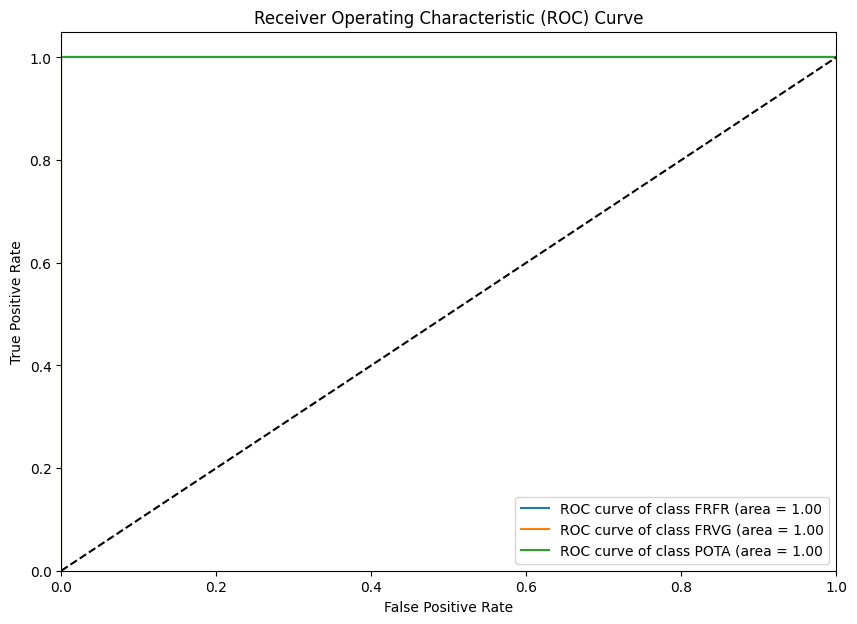

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: CUFD Classifier
Cleaning Dataset of Model: CUFD Classifier
Encoding Labels of Model: CUFD Classifier
{'BRKF': 0, 'BSOI': 1, 'CANF': 2, 'RICE': 3}
Splitting Data of Model: CUFD Classifier
Tokenizing: CUFD Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: CUFD Classifier
Using device: cuda
Training of Model: CUFD Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.164386028951069
Validation loss: 0.796434673998091
F1 Score (Weighted): 0.6887084308867321


Epoch 2:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5026420922774189
Validation loss: 0.27166591584682465
F1 Score (Weighted): 0.9749782046237513


Epoch 3:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.15961244357925541
Validation loss: 0.1629549696765564
F1 Score (Weighted): 0.9623497007256742


Epoch 4:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.07983670074422404
Validation loss: 0.13213401701715258
F1 Score (Weighted): 0.9749782046237513


Epoch 5:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.05838060424715843
Validation loss: 0.12993859934310117
F1 Score (Weighted): 0.9749782046237513
Testing Model: CUFD Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: BRKF
Accuracy: 15/16

Class: BSOI
Accuracy: 28/28

Class: CANF
Accuracy: 21/22

Class: RICE
Accuracy: 14/14



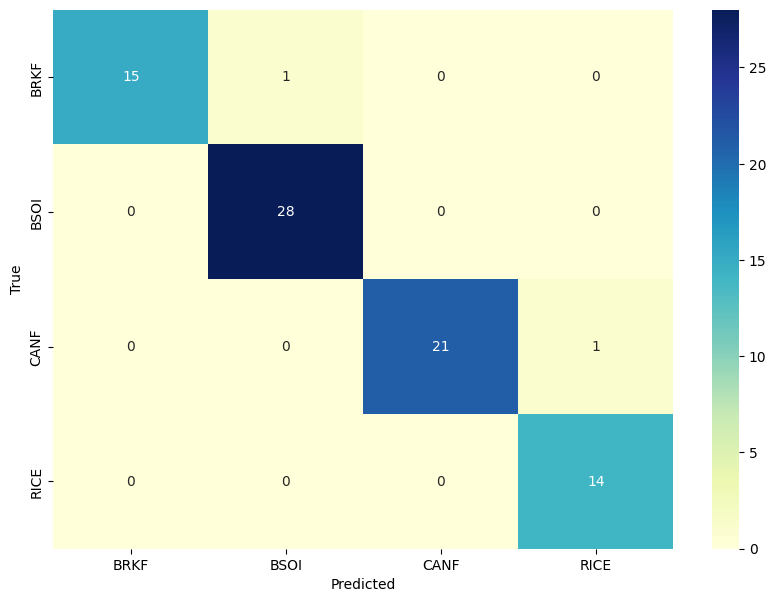

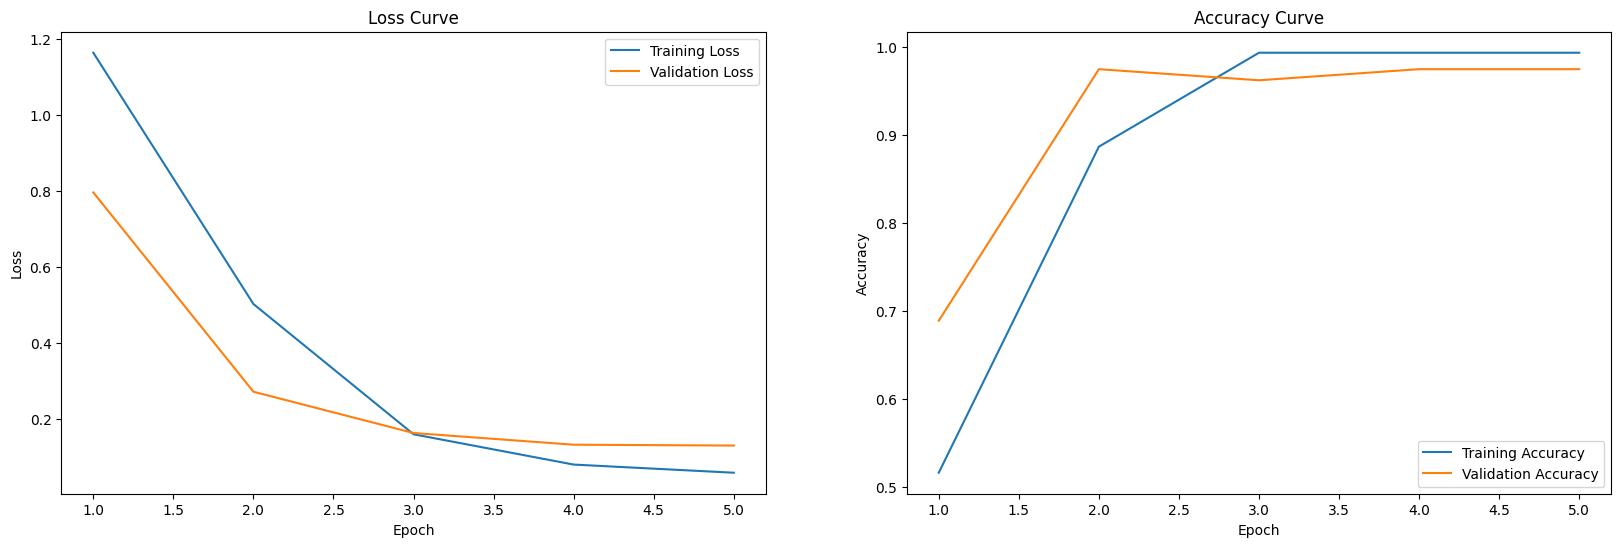

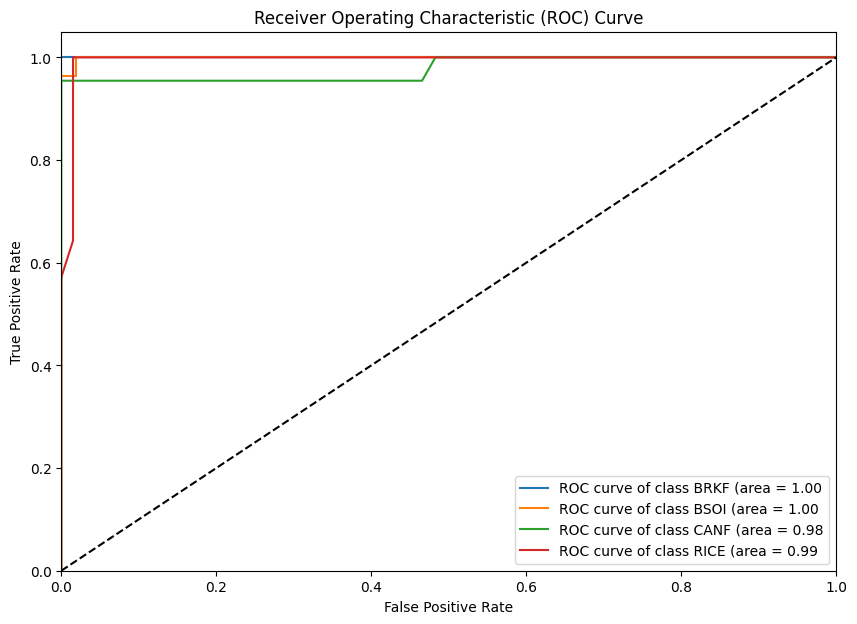

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: BAKY Classifier
Cleaning Dataset of Model: BAKY Classifier
Encoding Labels of Model: BAKY Classifier
{'BRRL': 0, 'INCK': 1, 'PKWT': 2, 'WHBR': 3, 'WHMB': 4}
Splitting Data of Model: BAKY Classifier
Tokenizing: BAKY Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: BAKY Classifier
Using device: cuda
Training of Model: BAKY Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.5684594073716331
Validation loss: 1.4428324629278744
F1 Score (Weighted): 0.7723417540390768


Epoch 2:   0%|          | 0/68 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.2781370650319492
Validation loss: 1.0278213444878073
F1 Score (Weighted): 0.8584317461206918


Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.9270234581302194
Validation loss: 0.7432104051113129
F1 Score (Weighted): 0.9225341130604289


Epoch 4:   0%|          | 0/68 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.6876993323950207
Validation loss: 0.6124405001892763
F1 Score (Weighted): 0.9225341130604289


Epoch 5:   0%|          | 0/68 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.5806194149395999
Validation loss: 0.5665959154858309
F1 Score (Weighted): 0.9225341130604289
Testing Model: BAKY Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: BRRL
Accuracy: 10/11

Class: INCK
Accuracy: 8/10

Class: PKWT
Accuracy: 9/10

Class: WHBR
Accuracy: 12/12

Class: WHMB
Accuracy: 8/8



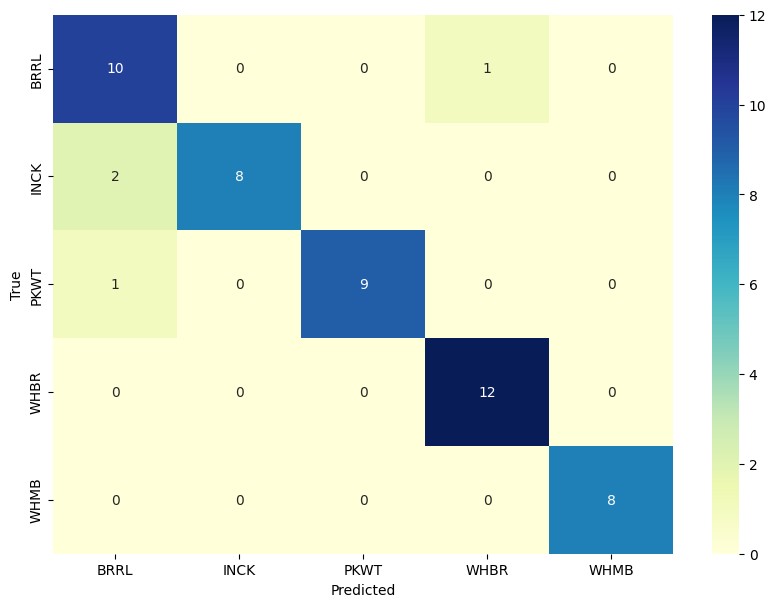

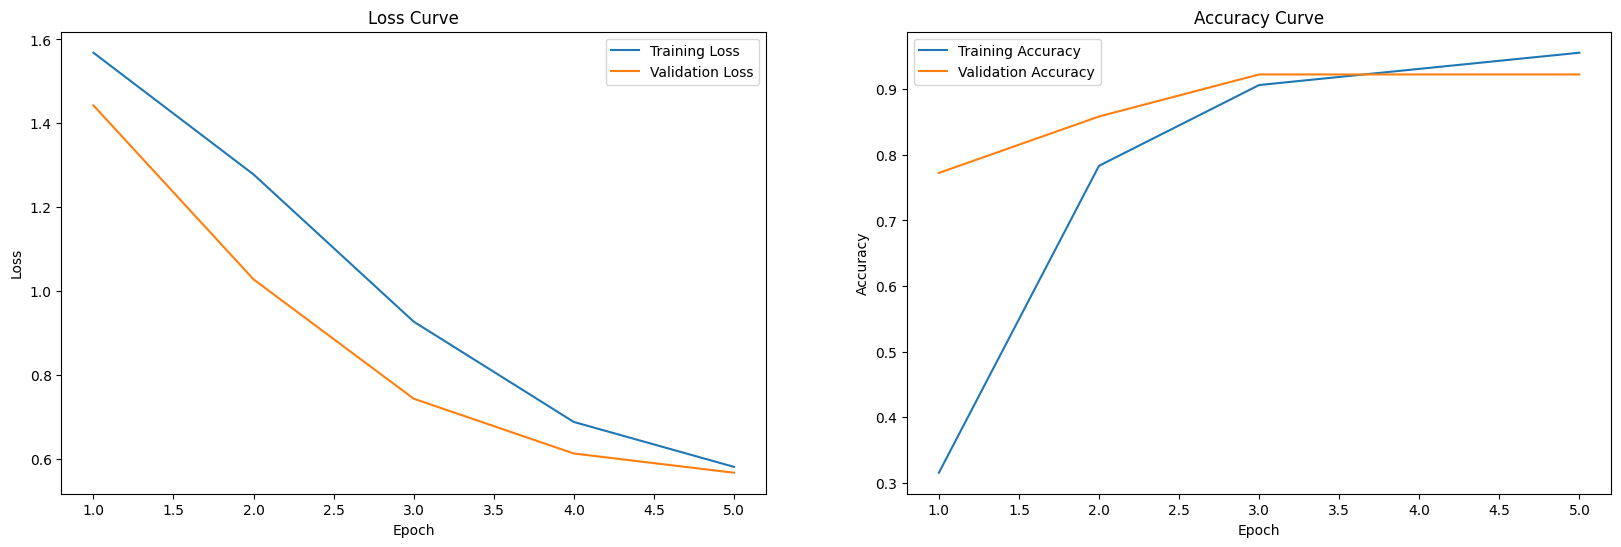

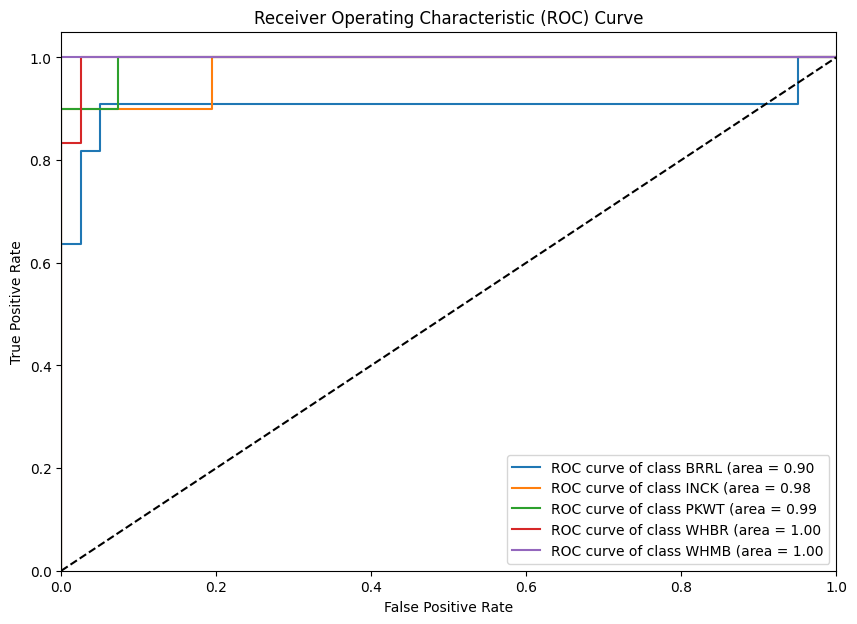

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: BKGD Classifier
Cleaning Dataset of Model: BKGD Classifier
Encoding Labels of Model: BKGD Classifier
{'SRFL': 0, 'OTFL': 1, 'PWSU': 2}
Splitting Data of Model: BKGD Classifier
Tokenizing: BKGD Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: BKGD Classifier
Using device: cuda
Training of Model: BKGD Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0668153817003423
Validation loss: 0.9875487685203552
F1 Score (Weighted): 0.7


Epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8914359139673638
Validation loss: 0.7536139289538065
F1 Score (Weighted): 0.739047619047619


Epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6345975633823511
Validation loss: 0.5391103757752312
F1 Score (Weighted): 0.7733333333333333


Epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.4613704022132989
Validation loss: 0.4173375533686744
F1 Score (Weighted): 0.8518260869565217


Epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.3724167753349651
Validation loss: 0.3824680530362659
F1 Score (Weighted): 0.9103030303030303
Testing Model: BKGD Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: SRFL
Accuracy: 1/4

Class: OTFL
Accuracy: 10/10

Class: PWSU
Accuracy: 11/11



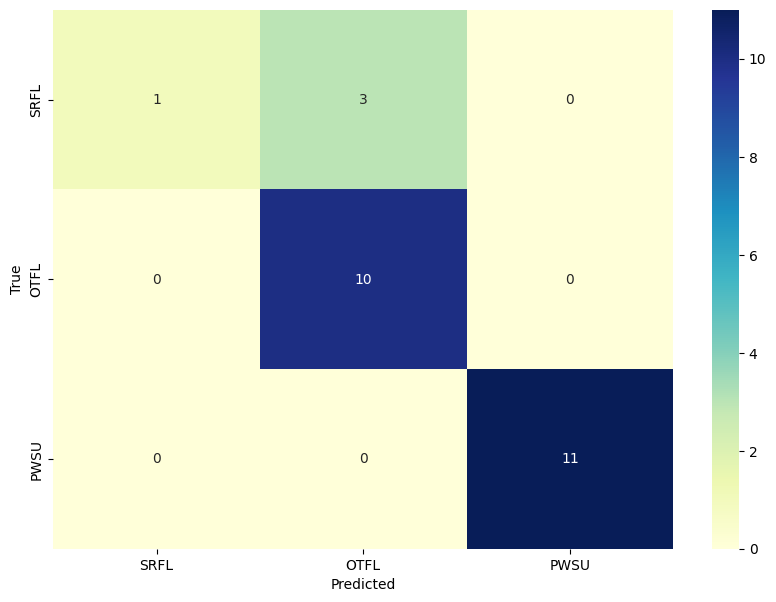

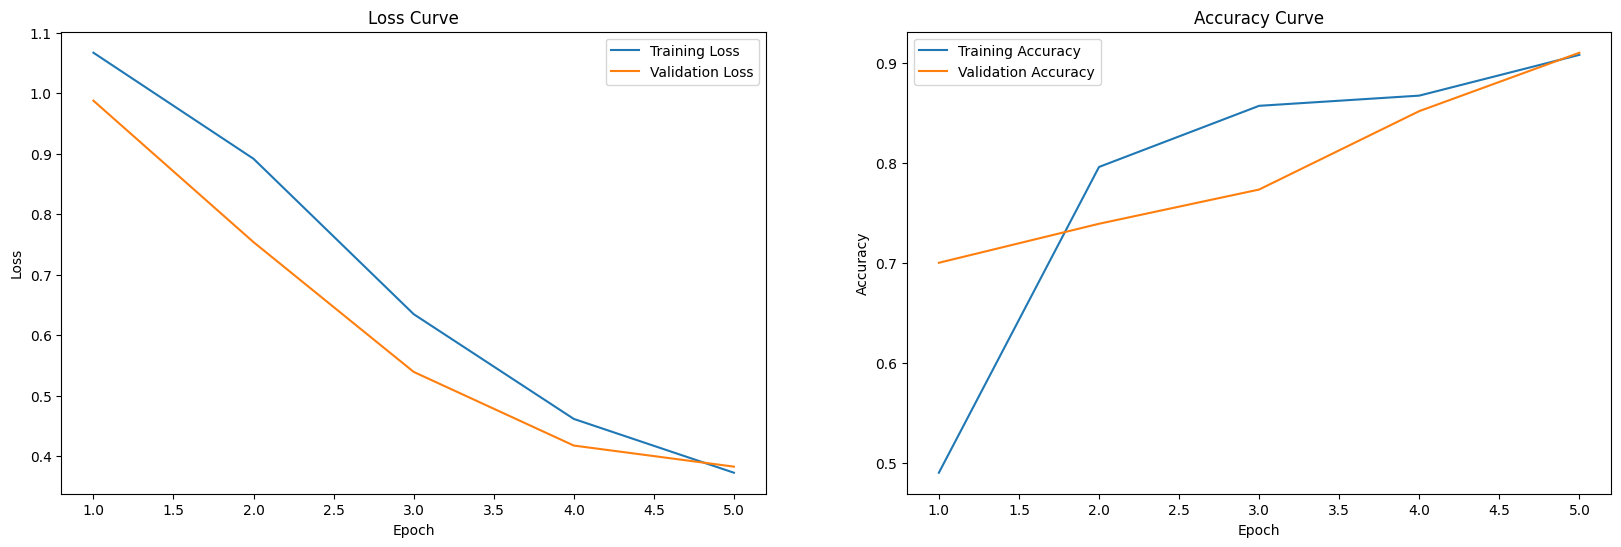

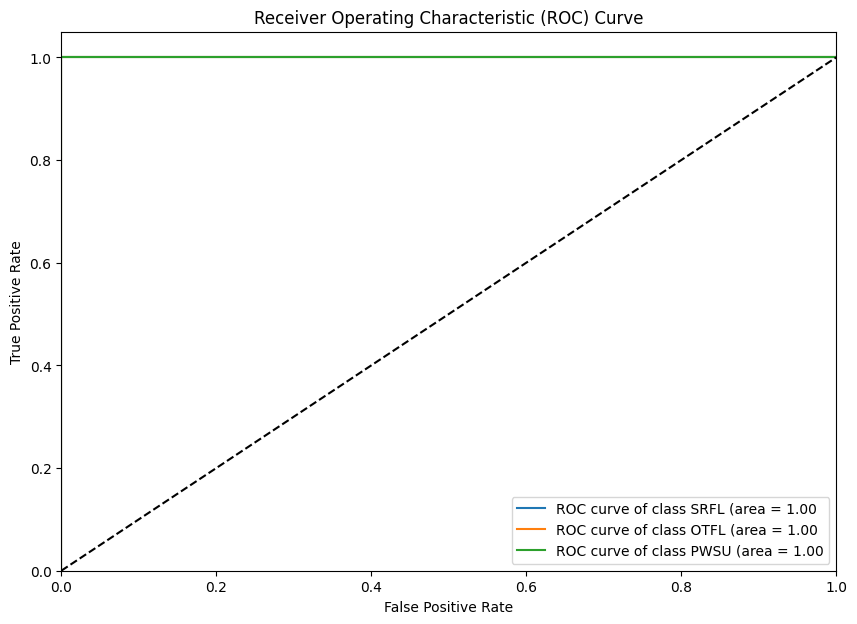

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: CHSW Classifier
Cleaning Dataset of Model: CHSW Classifier
Encoding Labels of Model: CHSW Classifier
{'CHOC': 0, 'GUMM': 1, 'OTSW': 2}
Splitting Data of Model: CHSW Classifier
Tokenizing: CHSW Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: CHSW Classifier
Using device: cuda
Training of Model: CHSW Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0555201477782672
Validation loss: 0.9612991213798523
F1 Score (Weighted): 0.2527401676337846


Epoch 2:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8796000882636669
Validation loss: 0.7992606840350411
F1 Score (Weighted): 0.3631466176920723


Epoch 3:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6847029300623162
Validation loss: 0.6248072426427494
F1 Score (Weighted): 0.8712121212121212


Epoch 4:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.4864826846954434
Validation loss: 0.5186015062711455
F1 Score (Weighted): 0.9054683456960496


Epoch 5:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.3842210520145505
Validation loss: 0.4920910102399913
F1 Score (Weighted): 0.9054683456960496
Testing Model: CHSW Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: CHOC
Accuracy: 9/9

Class: GUMM
Accuracy: 14/14

Class: OTSW
Accuracy: 7/10



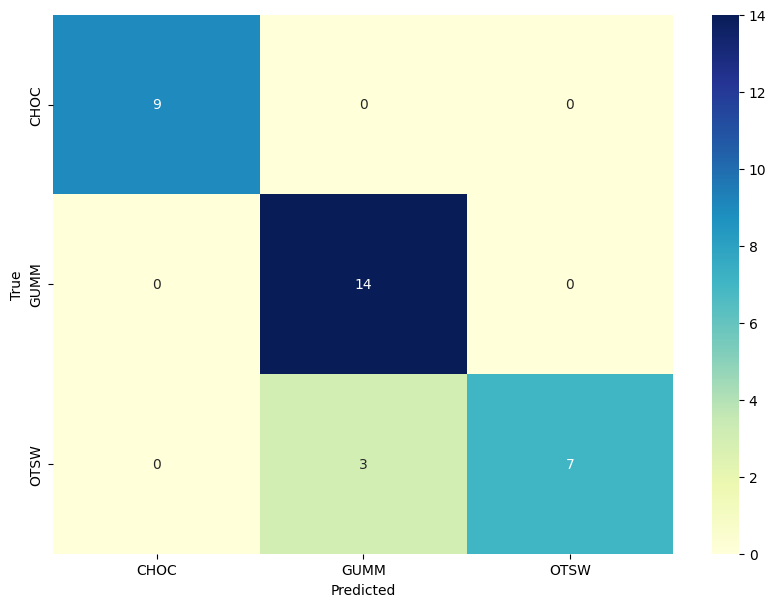

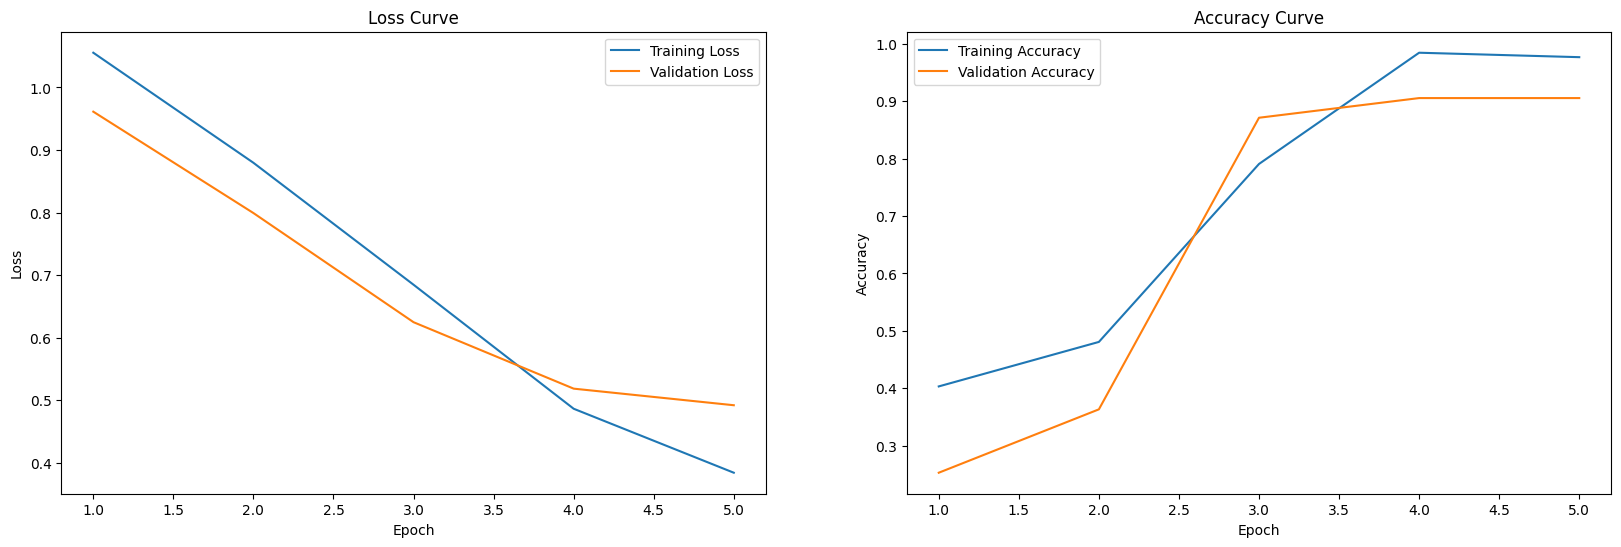

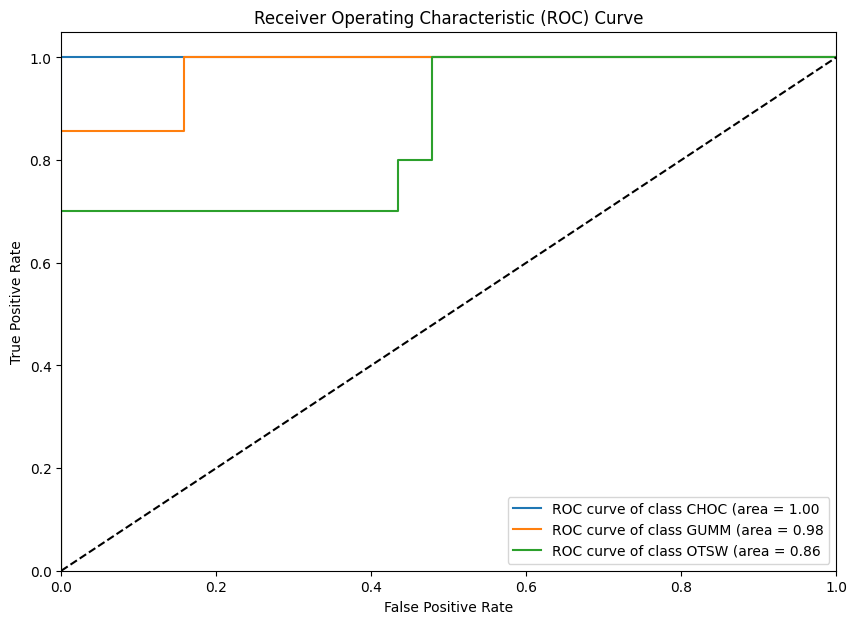

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: JAMH Classifier
Cleaning Dataset of Model: JAMH Classifier
Encoding Labels of Model: JAMH Classifier
{'HONY': 0, 'JAMM': 1, 'CRSP': 2}
Splitting Data of Model: JAMH Classifier
Tokenizing: JAMH Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: JAMH Classifier
Using device: cuda
Training of Model: JAMH Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0045996038686662
Validation loss: 0.8193451762199402
F1 Score (Weighted): 0.8017099591651543


Epoch 2:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6872440179189047
Validation loss: 0.48002886230295355
F1 Score (Weighted): 0.9685526315789474


Epoch 3:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.4374939600626628
Validation loss: 0.31972662901336496
F1 Score (Weighted): 0.9685526315789474


Epoch 4:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2860898253108774
Validation loss: 0.23156432671980423
F1 Score (Weighted): 0.9685526315789474


Epoch 5:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.2215432920271442
Validation loss: 0.21329165317795493
F1 Score (Weighted): 0.9685526315789474
Testing Model: JAMH Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: HONY
Accuracy: 10/10

Class: JAMM
Accuracy: 9/10

Class: CRSP
Accuracy: 12/12



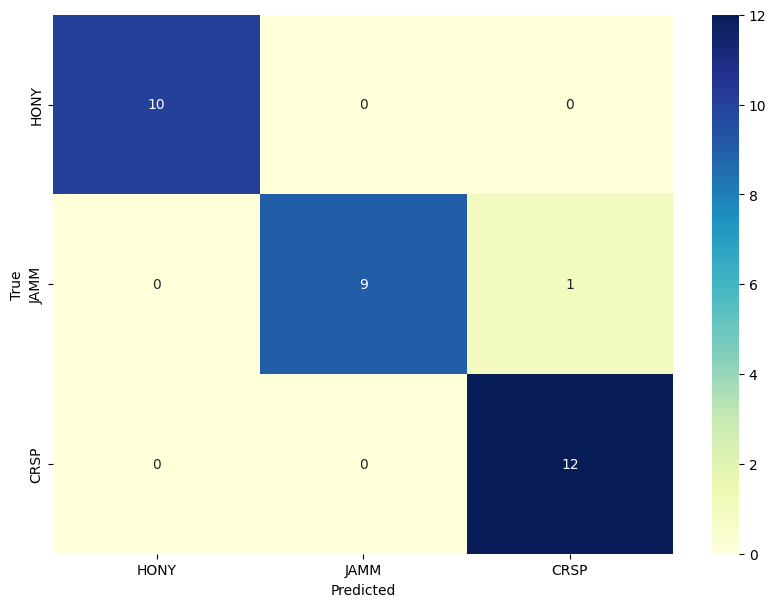

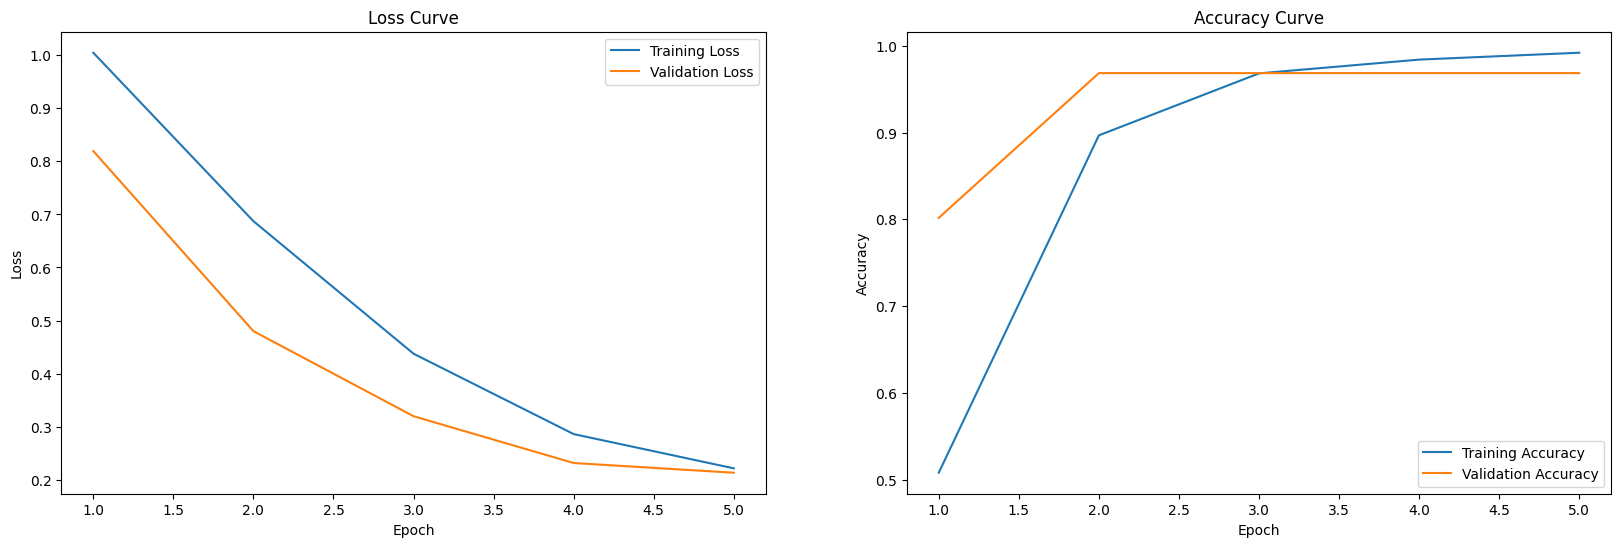

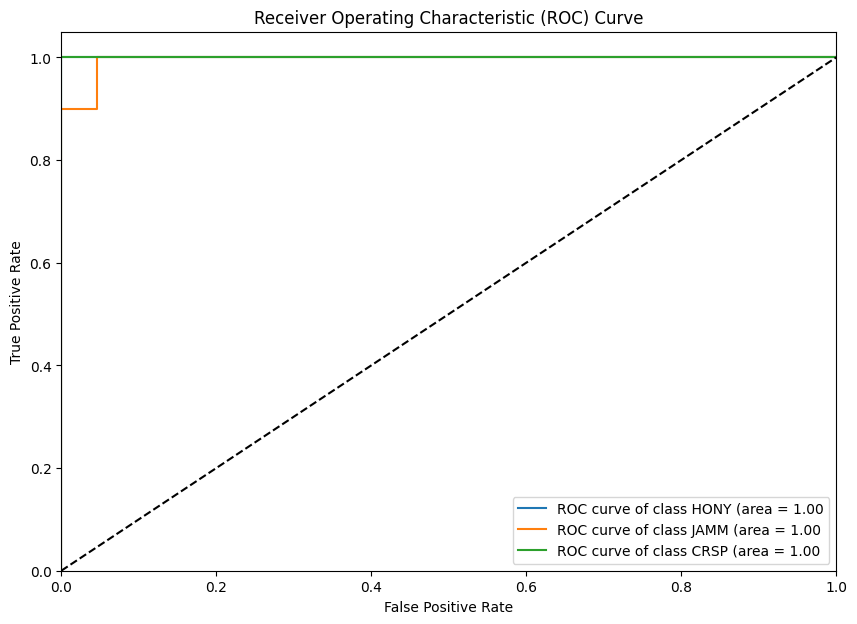

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: DAIR Classifier
Cleaning Dataset of Model: DAIR Classifier
Encoding Labels of Model: DAIR Classifier
{'CHCH': 0, 'EGGS': 1, 'SKML': 2, 'SFCH': 3, 'WHMK': 4}
Splitting Data of Model: DAIR Classifier
Tokenizing: DAIR Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: DAIR Classifier
Using device: cuda
Training of Model: DAIR Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.513933186729749
Validation loss: 1.3353189046566303
F1 Score (Weighted): 0.674951411793517


Epoch 2:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.1576814229289691
Validation loss: 0.9430752534132737
F1 Score (Weighted): 0.8460980460980462


Epoch 3:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.8289473857730627
Validation loss: 0.6762556433677673
F1 Score (Weighted): 0.8107430739009687


Epoch 4:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.6370545669148365
Validation loss: 0.5530717923091009
F1 Score (Weighted): 0.9056511056511056


Epoch 5:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.55665749621888
Validation loss: 0.514419647363516
F1 Score (Weighted): 0.8846846846846848
Testing Model: DAIR Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: CHCH
Accuracy: 10/10

Class: EGGS
Accuracy: 9/9

Class: SKML
Accuracy: 4/4

Class: SFCH
Accuracy: 10/10

Class: WHMK
Accuracy: 1/4



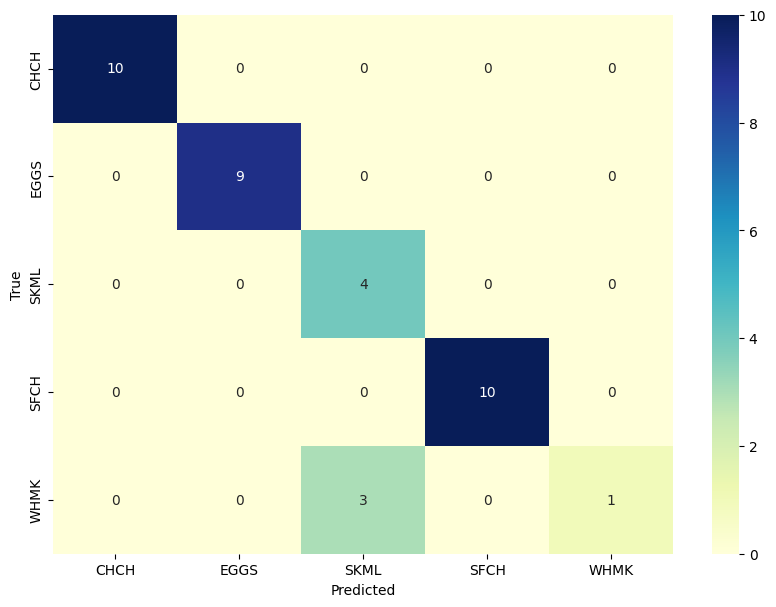

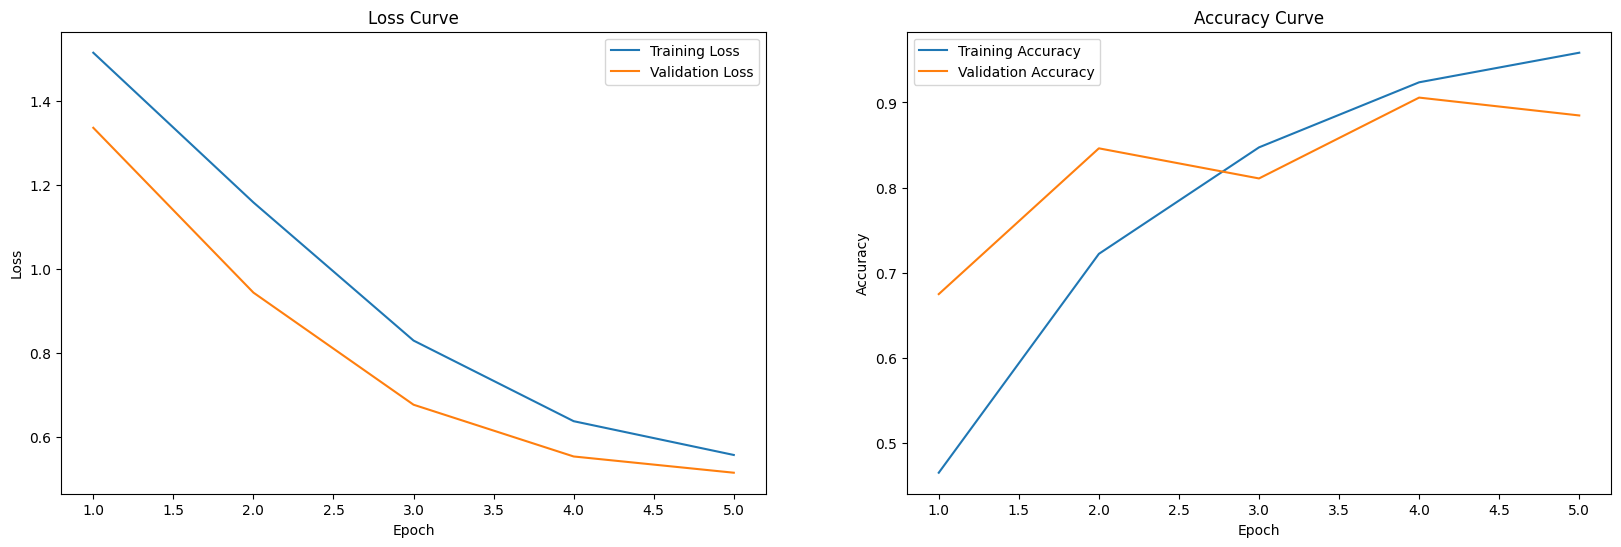

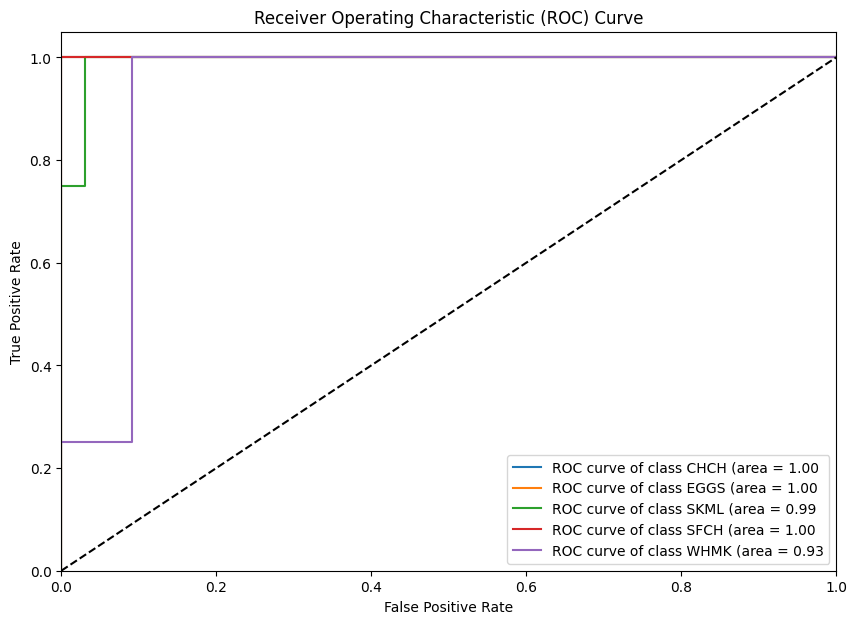

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: FISH Classifier
Cleaning Dataset of Model: FISH Classifier
Encoding Labels of Model: FISH Classifier
{'FSFF': 0, 'FWFF': 1, 'PRAW': 2}
Splitting Data of Model: FISH Classifier
Tokenizing: FISH Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: FISH Classifier
Using device: cuda
Training of Model: FISH Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0914996736928035
Validation loss: 1.037617552280426
F1 Score (Weighted): 0.16666666666666666


Epoch 2:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.0231527435152155
Validation loss: 0.944515335559845
F1 Score (Weighted): 0.8027065527065527


Epoch 3:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.9326702011258978
Validation loss: 0.8165588259696961
F1 Score (Weighted): 0.861111111111111


Epoch 4:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.8290261312534934
Validation loss: 0.7377533435821533
F1 Score (Weighted): 1.0


Epoch 5:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.7700245066692954
Validation loss: 0.7065539121627807
F1 Score (Weighted): 0.9326599326599326
Testing Model: FISH Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: FSFF
Accuracy: 5/5

Class: FWFF
Accuracy: 5/5

Class: PRAW
Accuracy: 5/5



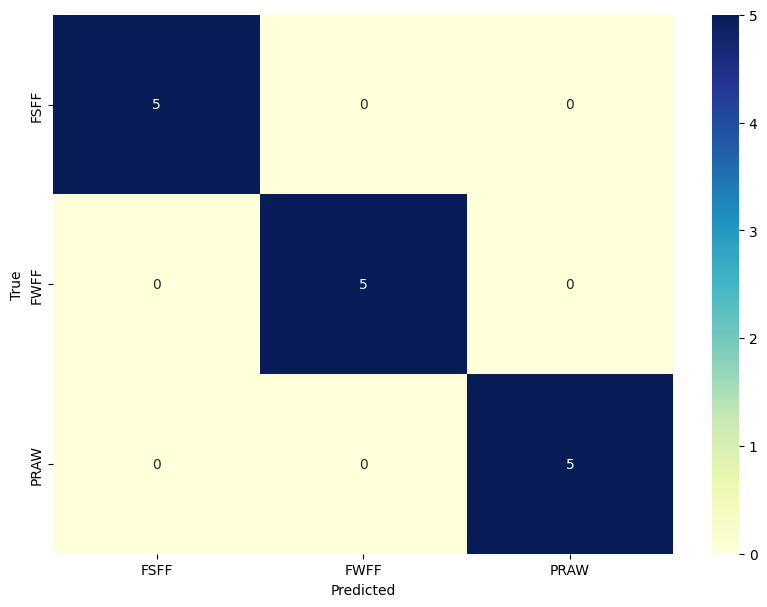

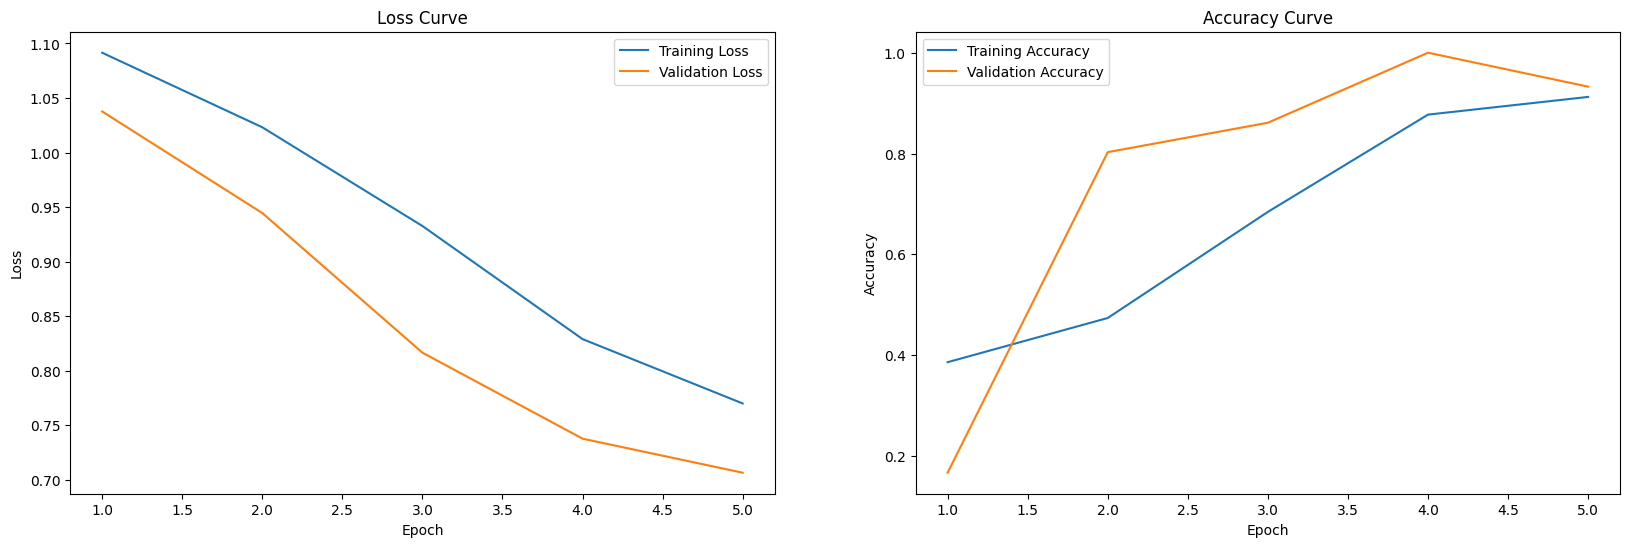

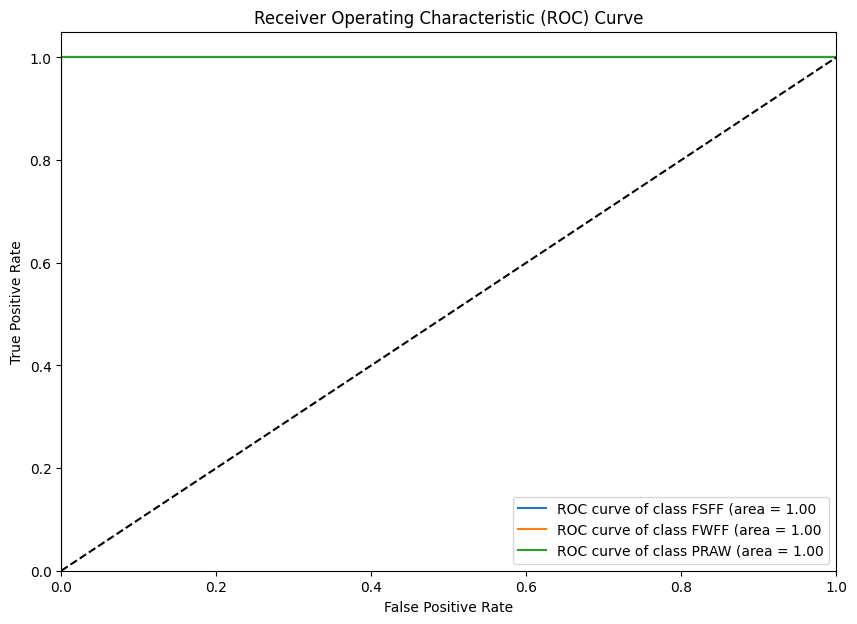

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: MEAT Classifier
Cleaning Dataset of Model: MEAT Classifier
Encoding Labels of Model: MEAT Classifier
{'PORK': 0, 'BEEF': 1, 'CHCK': 2, 'TURK': 3}
Splitting Data of Model: MEAT Classifier
Tokenizing: MEAT Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: MEAT Classifier
Using device: cuda
Training of Model: MEAT Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.258542737695906
Validation loss: 1.0151881834735041
F1 Score (Weighted): 0.6528051233195724


Epoch 2:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7000295610891448
Validation loss: 0.4261672872564067
F1 Score (Weighted): 0.9550268402470805


Epoch 3:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3482169239885277
Validation loss: 0.21686060564673465
F1 Score (Weighted): 0.9698734268048784


Epoch 4:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.201671368877093
Validation loss: 0.16452438821611198
F1 Score (Weighted): 0.9850830927608132


Epoch 5:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.16430204320285055
Validation loss: 0.15684886422494185
F1 Score (Weighted): 0.9850830927608132
Testing Model: MEAT Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: PORK
Accuracy: 17/17

Class: BEEF
Accuracy: 21/22

Class: CHCK
Accuracy: 20/20

Class: TURK
Accuracy: 8/8



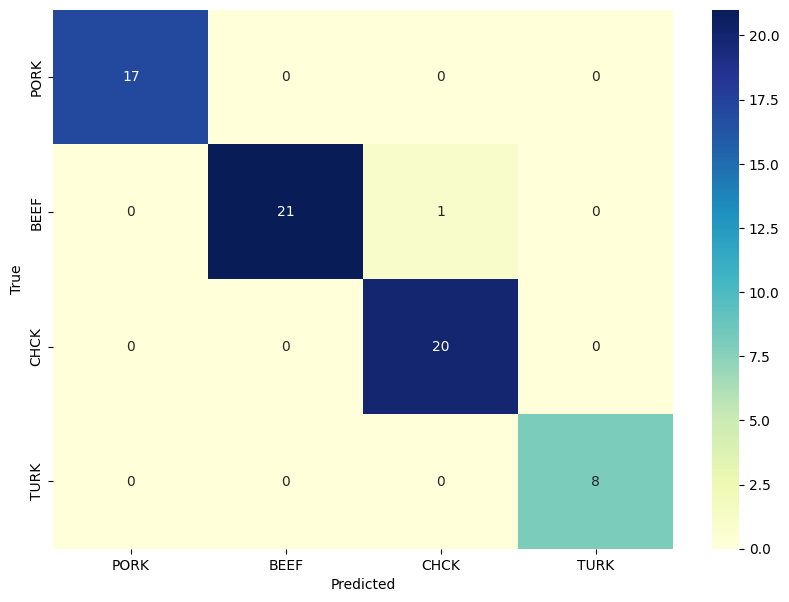

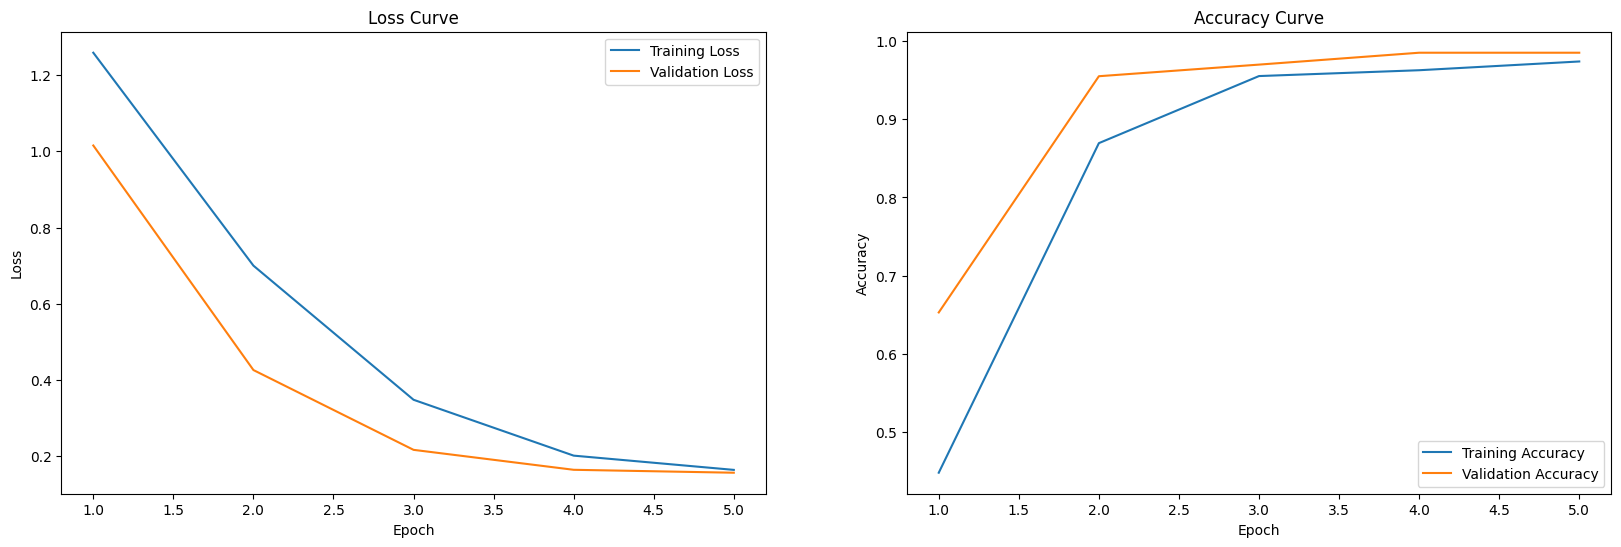

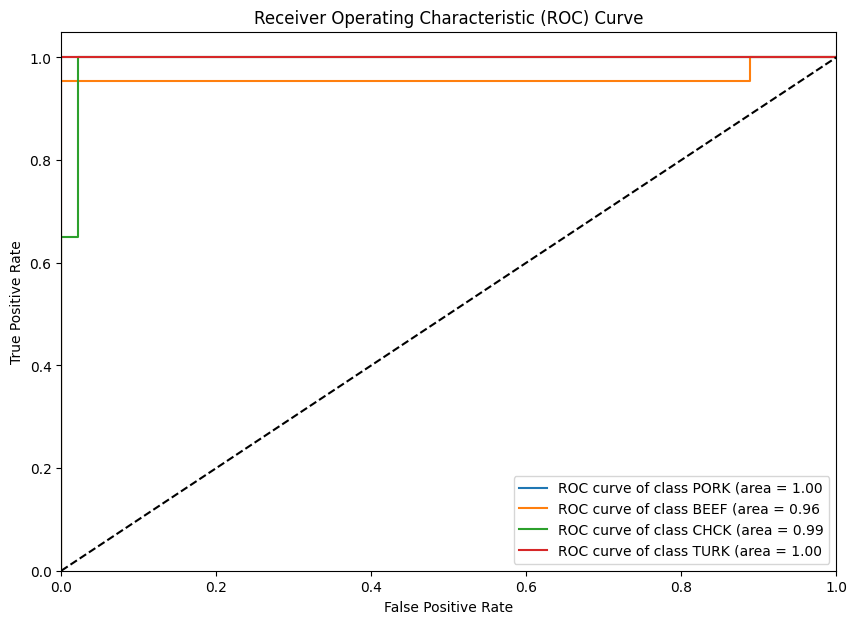

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: FRFR Classifier
Cleaning Dataset of Model: FRFR Classifier
Encoding Labels of Model: FRFR Classifier
{'AVOC': 0, 'BANA': 1, 'BLUE': 2, 'APPL': 3, 'GRAP': 4, 'KIWI': 5, 'LEMN': 6, 'ORNG': 7, 'PINE': 8, 'PLUM': 9, 'RASP': 10}
Splitting Data of Model: FRFR Classifier
Tokenizing: FRFR Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: FRFR Classifier
Using device: cuda
Training of Model: FRFR Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.272991098979912
Validation loss: 1.943859577178955
F1 Score (Weighted): 0.5070288760177957


Epoch 2:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.6703068301229194
Validation loss: 1.2395876966989958
F1 Score (Weighted): 0.9212422080843132


Epoch 3:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.1298786749934207
Validation loss: 0.820684708081759
F1 Score (Weighted): 0.986709197235513


Epoch 4:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.827616282618872
Validation loss: 0.6332965046167374
F1 Score (Weighted): 0.986709197235513


Epoch 5:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.7129542382046727
Validation loss: 0.5811088899007211
F1 Score (Weighted): 0.986709197235513
Testing Model: FRFR Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: AVOC
Accuracy: 10/10

Class: BANA
Accuracy: 7/7

Class: BLUE
Accuracy: 7/7

Class: APPL
Accuracy: 12/12

Class: GRAP
Accuracy: 9/9

Class: KIWI
Accuracy: 6/6

Class: LEMN
Accuracy: 5/5

Class: ORNG
Accuracy: 4/5

Class: PINE
Accuracy: 5/5

Class: PLUM
Accuracy: 5/5

Class: RASP
Accuracy: 5/5



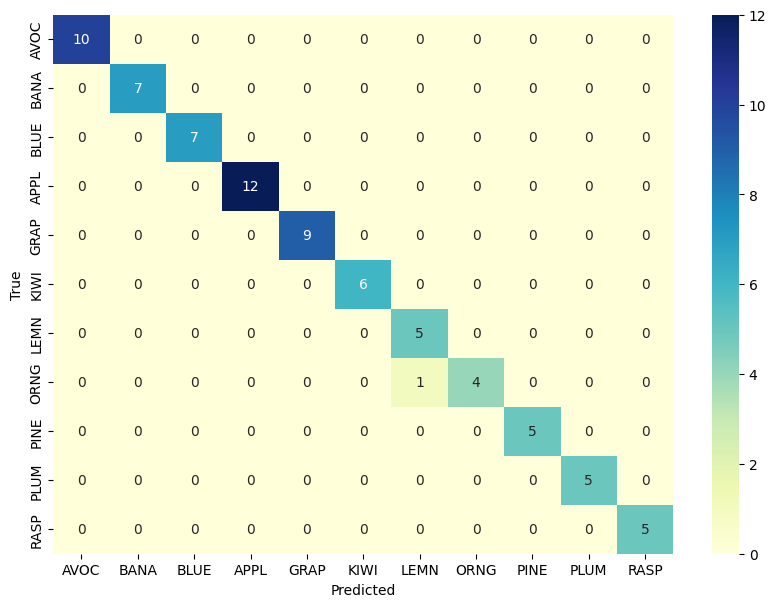

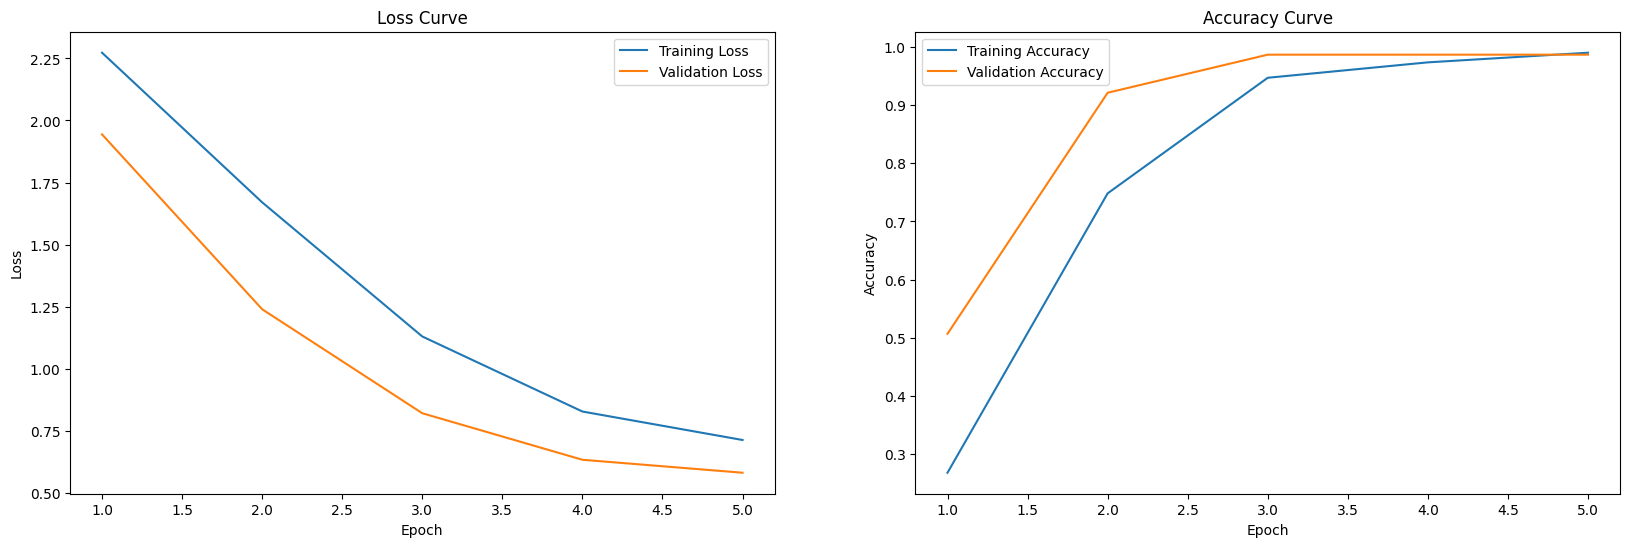

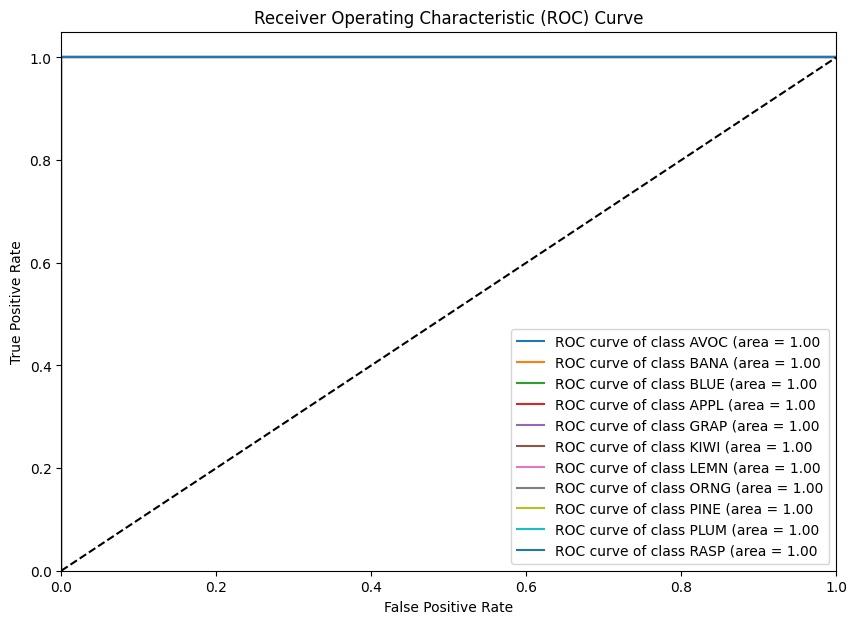

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: FRVG Classifier
Cleaning Dataset of Model: FRVG Classifier
Encoding Labels of Model: FRVG Classifier
{'BROC': 0, 'CARR': 1, 'CAUL': 2, 'CUCU': 3, 'LETT': 4, 'MUSH': 5, 'ONIO': 6, 'PEPP': 7, 'TOMA': 8, 'MXVG': 9}
Splitting Data of Model: FRVG Classifier
Tokenizing: FRVG Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: FRVG Classifier
Using device: cuda
Training of Model: FRVG Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/72 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.27181016239855
Validation loss: 2.1458193990919323
F1 Score (Weighted): 0.1500440917107584


Epoch 2:   0%|          | 0/72 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.9937322669559054
Validation loss: 1.743187407652537
F1 Score (Weighted): 0.5015889460333904


Epoch 3:   0%|          | 0/72 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.576021475924386
Validation loss: 1.3662360178099737
F1 Score (Weighted): 0.8080014851944678


Epoch 4:   0%|          | 0/72 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.290036684109105
Validation loss: 1.1634692516591814
F1 Score (Weighted): 0.8855922072296342


Epoch 5:   0%|          | 0/72 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.1559423547652032
Validation loss: 1.0928831580612395
F1 Score (Weighted): 0.9054057270431538
Testing Model: FRVG Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: BROC
Accuracy: 8/8

Class: CARR
Accuracy: 7/7

Class: CAUL
Accuracy: 2/4

Class: CUCU
Accuracy: 5/5

Class: LETT
Accuracy: 4/5

Class: MUSH
Accuracy: 4/6

Class: ONIO
Accuracy: 5/5

Class: PEPP
Accuracy: 4/4

Class: TOMA
Accuracy: 6/6

Class: MXVG
Accuracy: 3/4



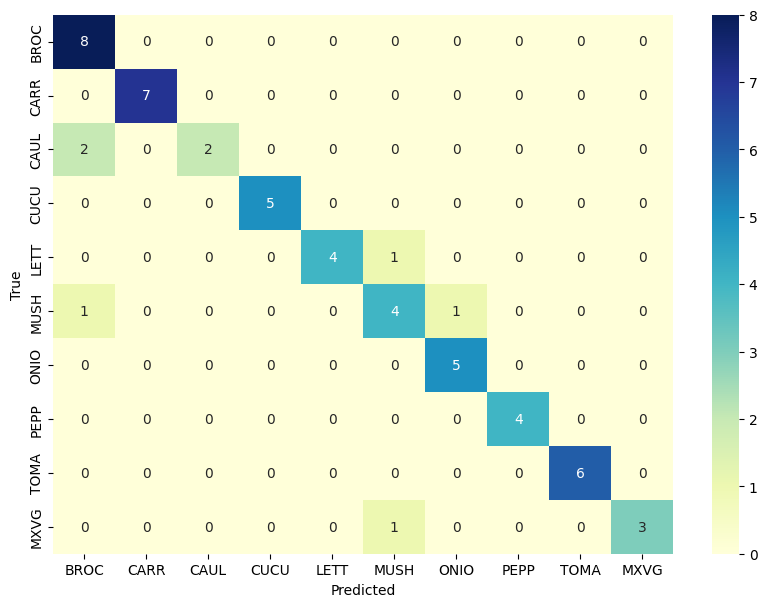

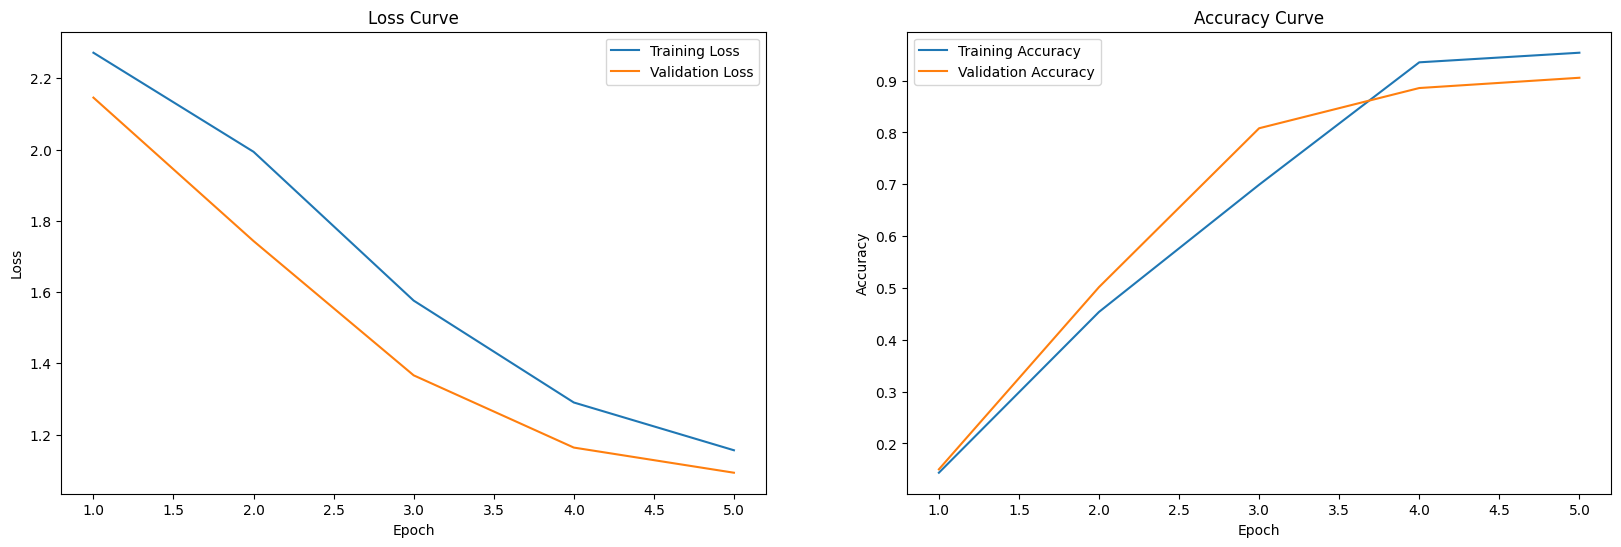

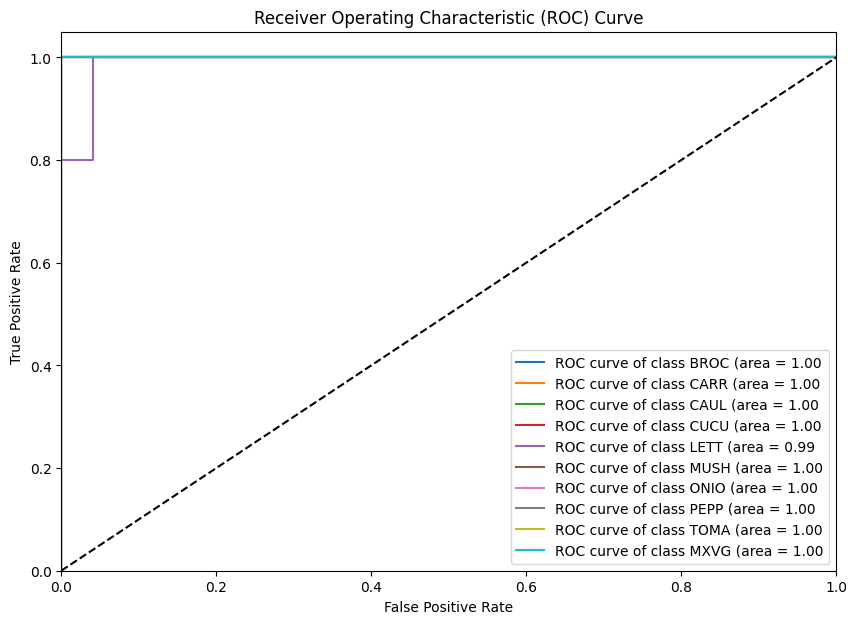

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: POTA Classifier
Cleaning Dataset of Model: POTA Classifier
Encoding Labels of Model: POTA Classifier
{'POTT': 0, 'SWPT': 1}
Splitting Data of Model: POTA Classifier
Tokenizing: POTA Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: POTA Classifier
Using device: cuda
Training of Model: POTA Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6926950931549072
Validation loss: 0.6741903424263
F1 Score (Weighted): 0.4807692307692308


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6486159205436707
Validation loss: 0.6626187562942505
F1 Score (Weighted): 0.4807692307692308


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6217597693204879
Validation loss: 0.6408937772115072
F1 Score (Weighted): 0.4807692307692308


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5898111075162887
Validation loss: 0.6201570928096771
F1 Score (Weighted): 0.4807692307692308


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.5663630545139313
Validation loss: 0.6133038202921549
F1 Score (Weighted): 0.4807692307692308
Testing Model: POTA Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: POTT
Accuracy: 5/5

Class: SWPT
Accuracy: 0/3



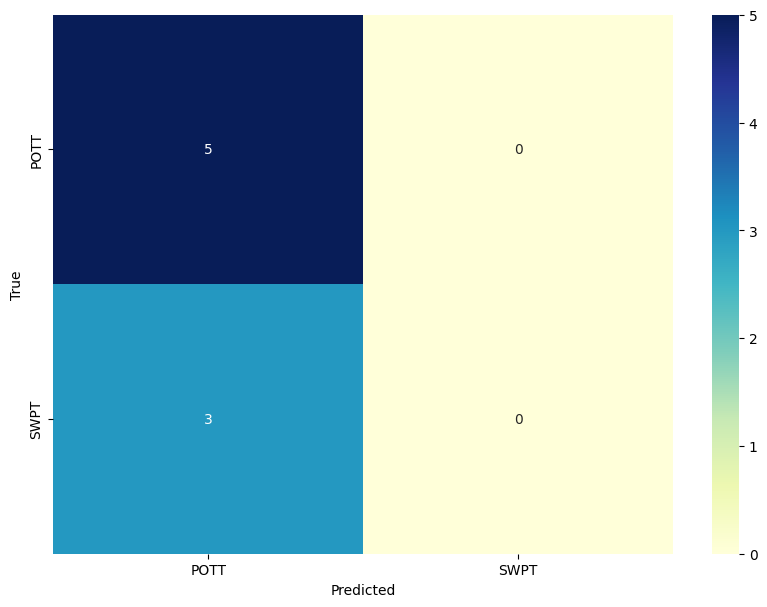

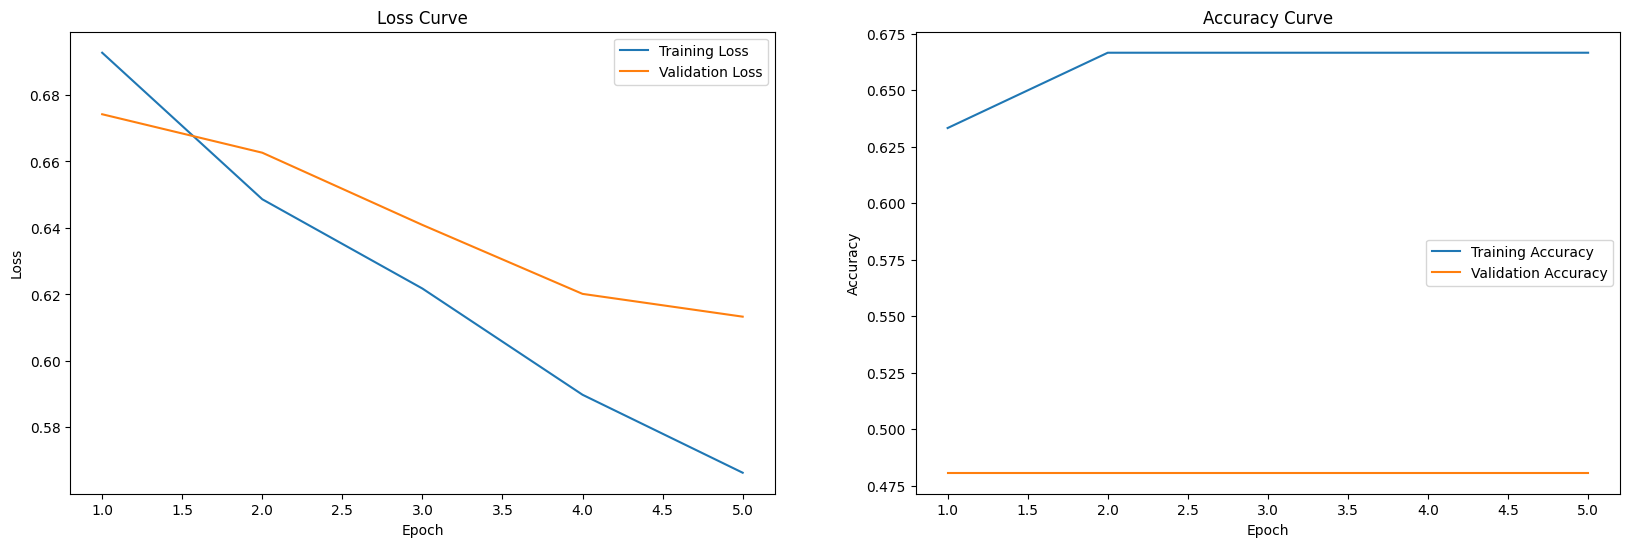

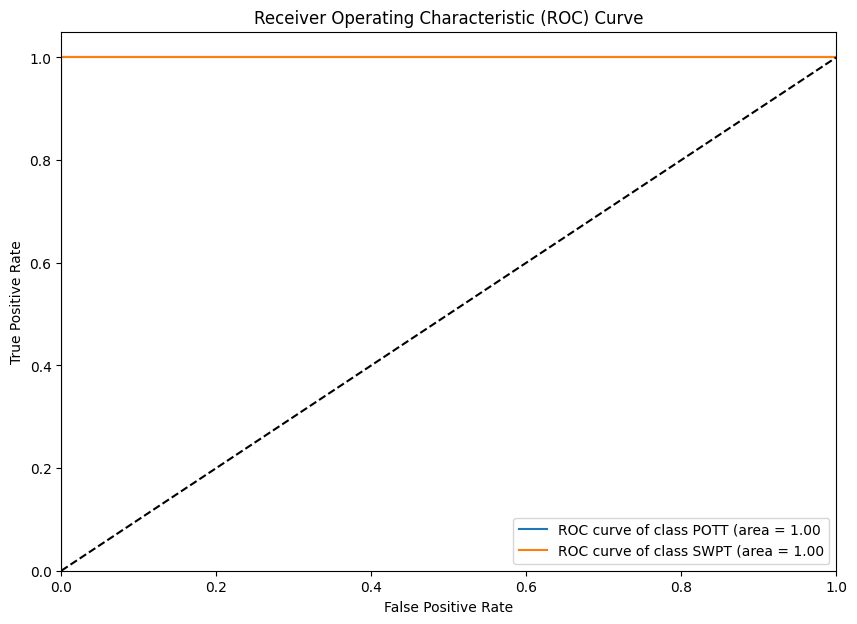

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: BRKF Classifier
Cleaning Dataset of Model: BRKF Classifier
Encoding Labels of Model: BRKF Classifier
{'BCGF': 0, 'BCER': 1}
Splitting Data of Model: BRKF Classifier
Tokenizing: BRKF Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: BRKF Classifier
Using device: cuda
Training of Model: BRKF Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.665390207653954
Validation loss: 0.6282743414243063
F1 Score (Weighted): 0.6071428571428571


Epoch 2:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5630104158605848
Validation loss: 0.4751592477162679
F1 Score (Weighted): 1.0


Epoch 3:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.4082086036602656
Validation loss: 0.2985125308235486
F1 Score (Weighted): 1.0


Epoch 4:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.27944883704185486
Validation loss: 0.2124987319111824
F1 Score (Weighted): 1.0


Epoch 5:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.22051126048678443
Validation loss: 0.18515439331531525
F1 Score (Weighted): 1.0
Testing Model: BRKF Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: BCGF
Accuracy: 6/6

Class: BCER
Accuracy: 10/10



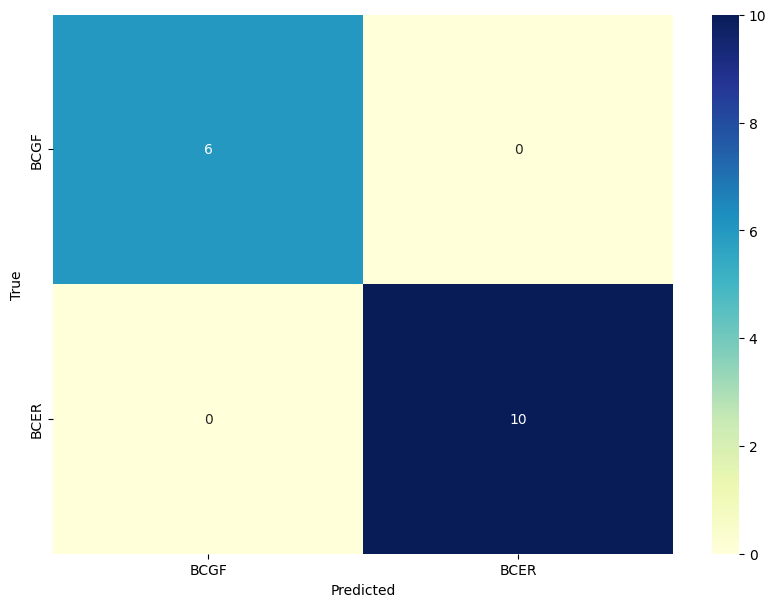

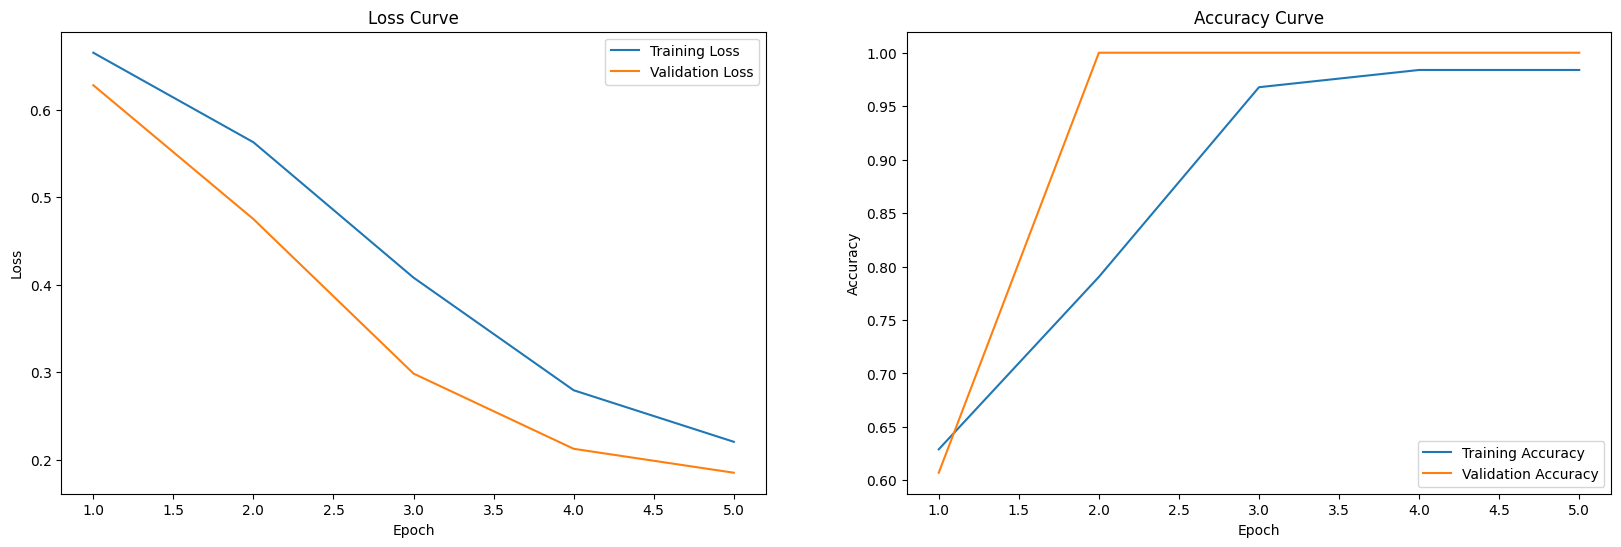

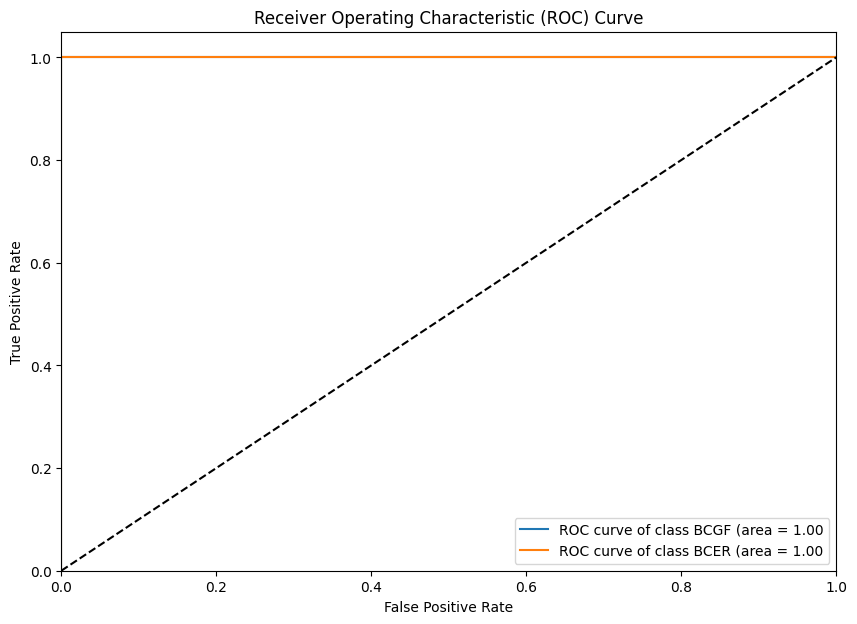

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: BSOI Classifier
Cleaning Dataset of Model: BSOI Classifier
Encoding Labels of Model: BSOI Classifier
{'BUTT': 0, 'MARG': 1, 'OLOL': 2}
Splitting Data of Model: BSOI Classifier
Tokenizing: BSOI Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: BSOI Classifier
Using device: cuda
Training of Model: BSOI Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.07570259152232
Validation loss: 0.9504450142383576
F1 Score (Weighted): 0.8820732838589981


Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.840097818825696
Validation loss: 0.5956356167793274
F1 Score (Weighted): 0.9637624280481424


Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5266755754883224
Validation loss: 0.314110141992569
F1 Score (Weighted): 1.0


Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.3259821002547805
Validation loss: 0.20819709897041322
F1 Score (Weighted): 1.0


Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.25698859425815374
Validation loss: 0.17983374372124672
F1 Score (Weighted): 1.0
Testing Model: BSOI Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: BUTT
Accuracy: 7/7

Class: MARG
Accuracy: 11/11

Class: OLOL
Accuracy: 10/10



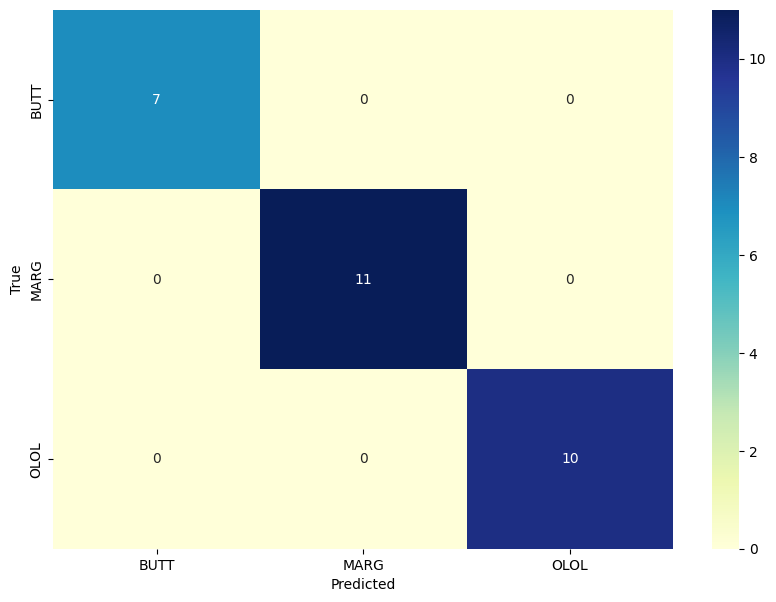

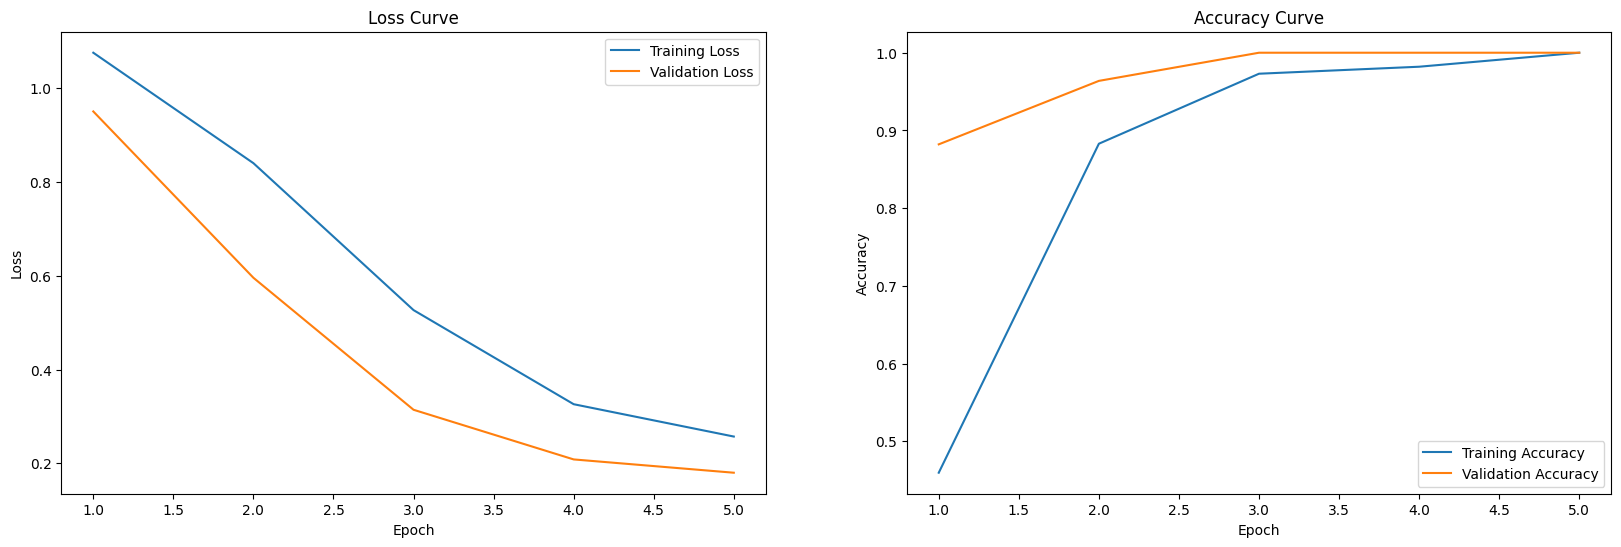

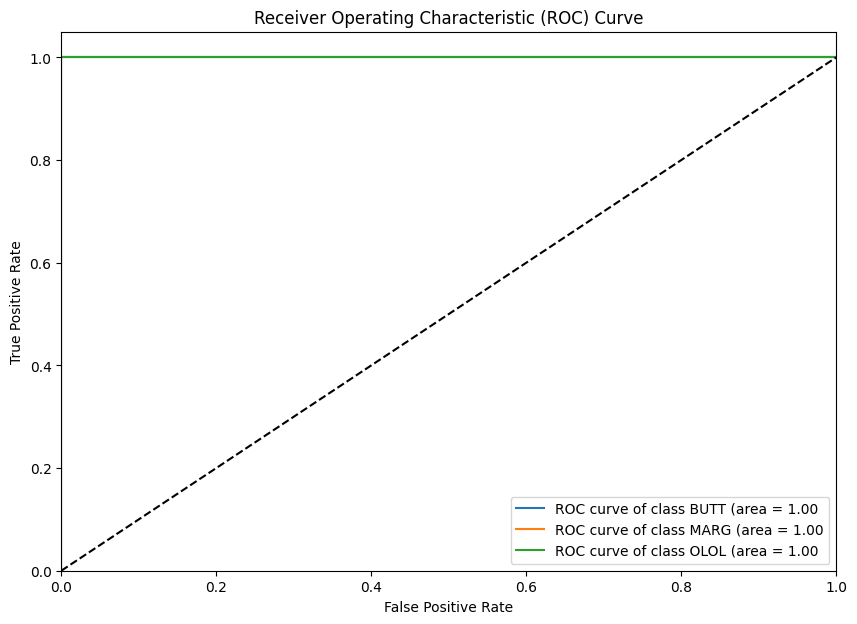

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: CANF Classifier
Cleaning Dataset of Model: CANF Classifier
Encoding Labels of Model: CANF Classifier
{'CTUN': 0, 'BKBN': 1, 'CNFR': 2}
Splitting Data of Model: CANF Classifier
Tokenizing: CANF Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: CANF Classifier
Using device: cuda
Training of Model: CANF Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/29 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0243065192781646
Validation loss: 0.9081057533621788
F1 Score (Weighted): 0.3333333333333333


Epoch 2:   0%|          | 0/29 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8008204318326095
Validation loss: 0.6904737632721663
F1 Score (Weighted): 0.6945454545454545


Epoch 3:   0%|          | 0/29 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6280040663891825
Validation loss: 0.5347208548337221
F1 Score (Weighted): 0.7474747474747474


Epoch 4:   0%|          | 0/29 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5008150095055843
Validation loss: 0.44719173293560743
F1 Score (Weighted): 0.7474747474747474


Epoch 5:   0%|          | 0/29 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.44566138730994587
Validation loss: 0.4218941554427147
F1 Score (Weighted): 0.7474747474747474
Testing Model: CANF Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: CTUN
Accuracy: 7/7

Class: BKBN
Accuracy: 11/11

Class: CNFR
Accuracy: 0/4



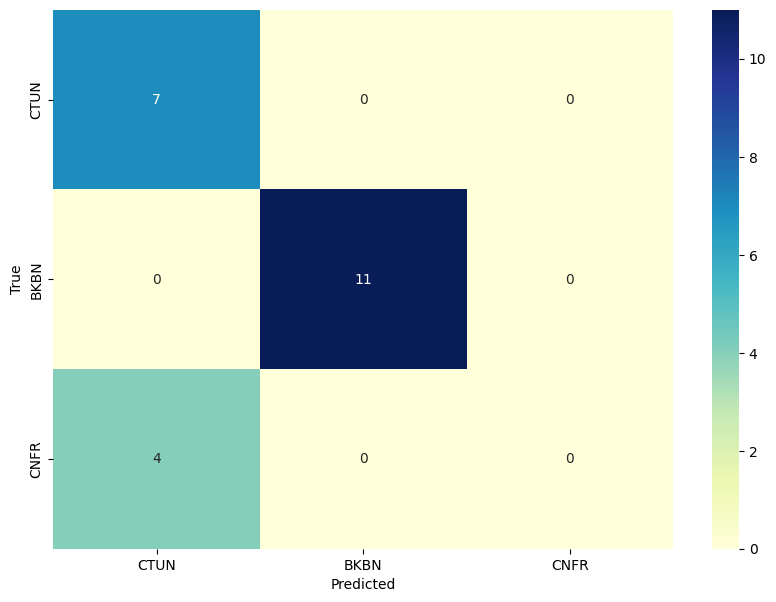

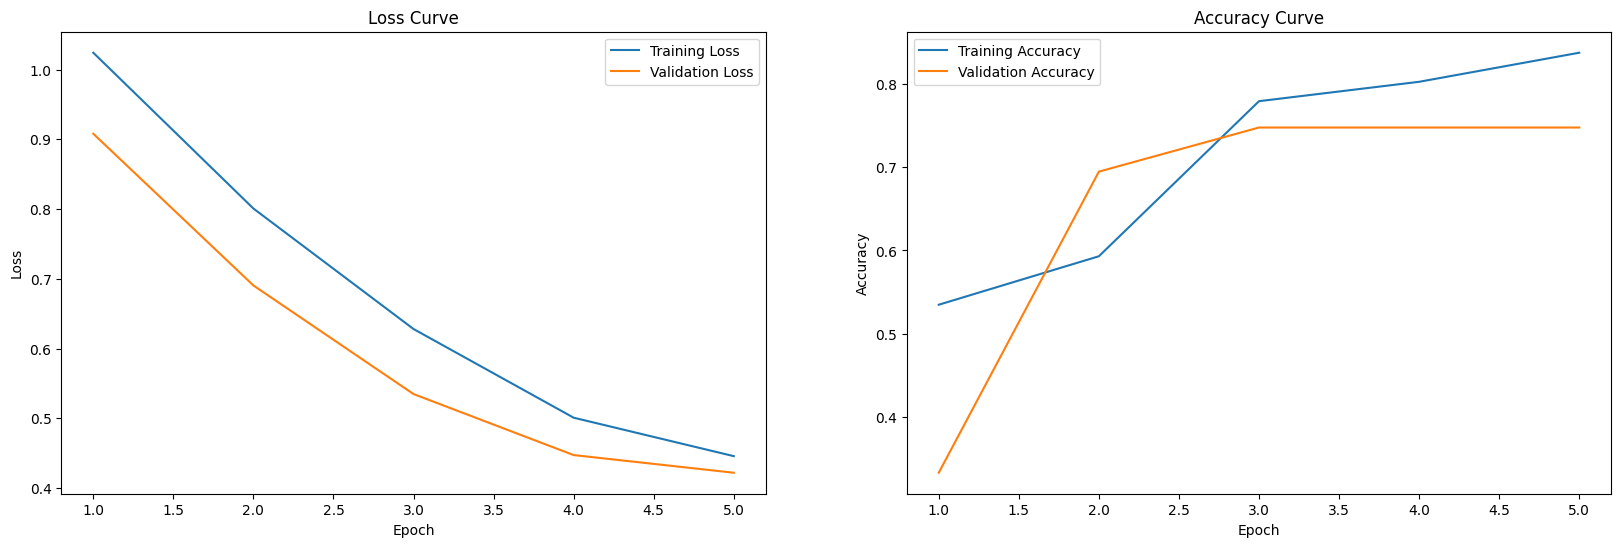

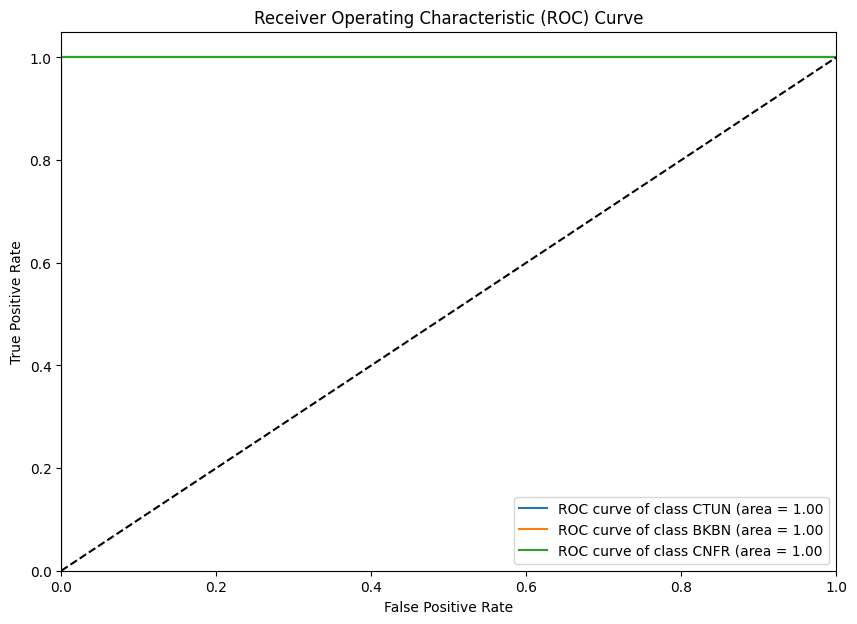

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: RICE Classifier
Cleaning Dataset of Model: RICE Classifier
Encoding Labels of Model: RICE Classifier
{'BSRX': 0, 'JSRX': 1, 'LGRX': 2}
Splitting Data of Model: RICE Classifier
Tokenizing: RICE Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

Loading Data of Model: RICE Classifier
Using device: cuda
Training of Model: RICE Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0724615067243577
Validation loss: 0.9784557819366455
F1 Score (Weighted): 0.8066666666666666


Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.9098499864339828
Validation loss: 0.7238997220993042
F1 Score (Weighted): 0.8066666666666666


Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6991312399506568
Validation loss: 0.561324167251587
F1 Score (Weighted): 0.8066666666666666


Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5717616662383079
Validation loss: 0.4682387948036194
F1 Score (Weighted): 0.8066666666666666


Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.47985542342066767
Validation loss: 0.4388915091753006
F1 Score (Weighted): 0.8066666666666666
Testing Model: RICE Classifier


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Class: BSRX
Accuracy: 9/9

Class: JSRX
Accuracy: 0/2

Class: LGRX
Accuracy: 4/4



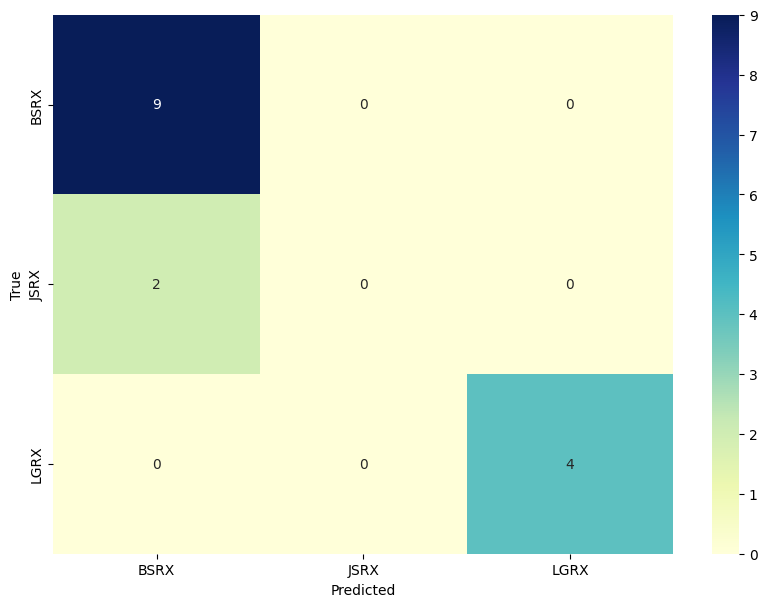

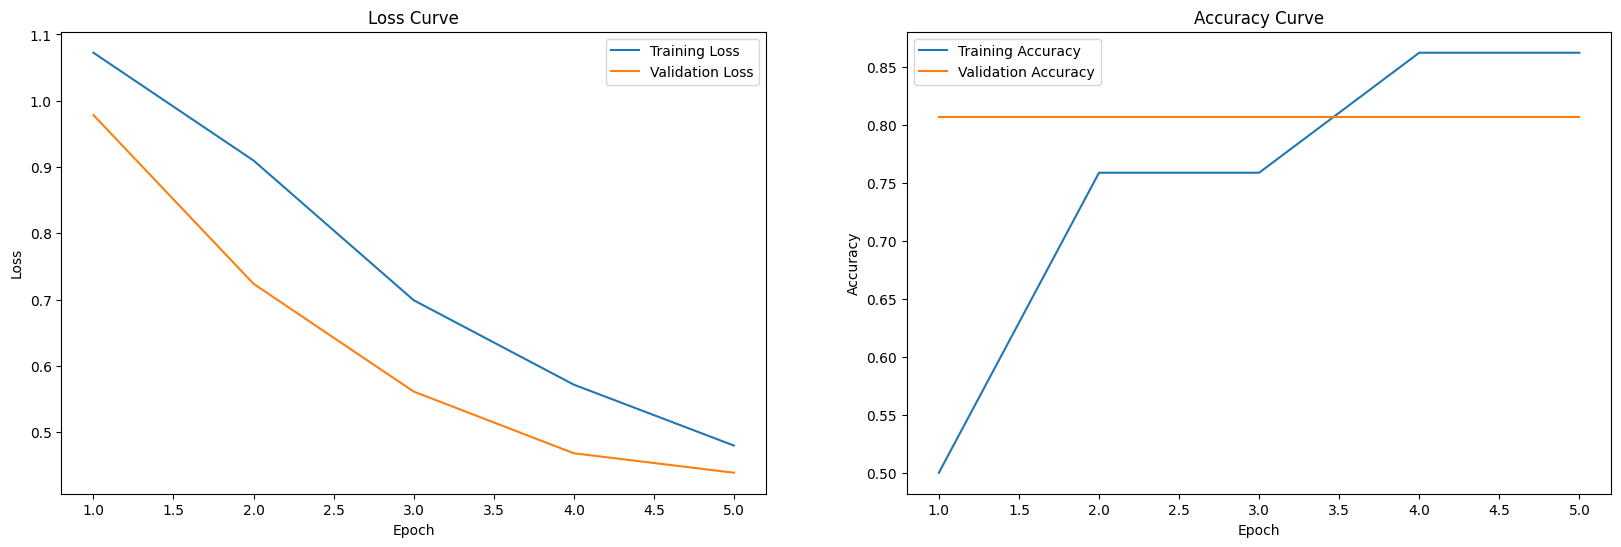

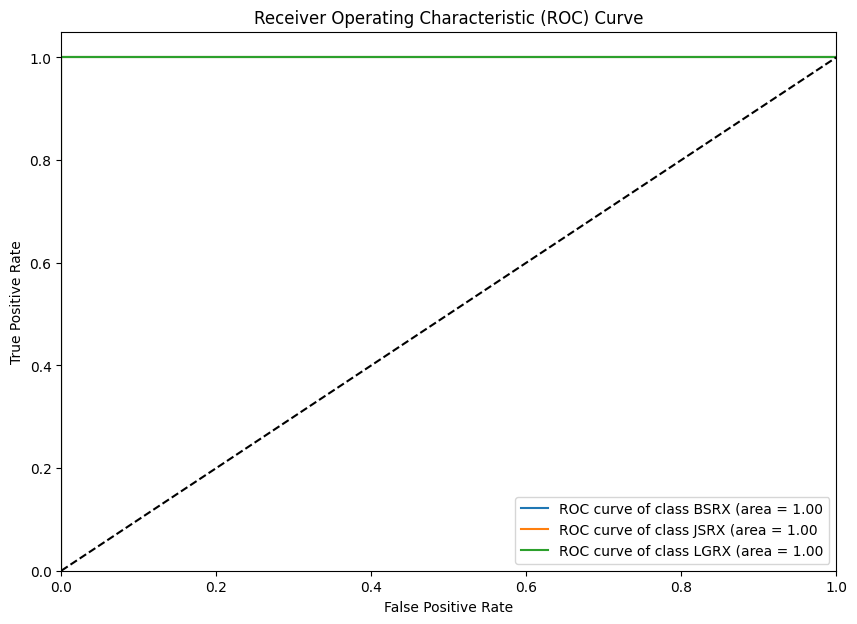

In [16]:
COLS = ["CATEGORY", "NAME"]
# Original LR = 1e-5
EPOCHS = 5
BATCH_SIZE = 3
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.001
GRADIENT_CLIPPING = 0.5
DROPOUT_RATE = 0.1
# Model 1: Food or Beverage  
torch.cuda.empty_cache()
model_trainer(
    DATA_SET_PATH='../Data/food_bevCAT.csv',
    SAVE_PATH='models/food_beverage_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="Food And Beverage Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()


# Food Model 1: FDAA Type (Food Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/FDAACat.csv',
    SAVE_PATH='models/fdaa_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="FDAA Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()


# Beverage Model 1: BEVA Type (Beverage Type)
model_trainer(
    DATA_SET_PATH='../Data/Beverage/BEVACat.csv',
    SAVE_PATH='models/beva_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="BEVA Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()


# Beverage Sub Category Models

## BEVA Model 1: SODR Type (Soft Drinks Type)
model_trainer(
    DATA_SET_PATH='../Data/Beverage/SODRCat.csv',
    SAVE_PATH='models/sodr_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="SODR Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

## BEVA Model 2: WATR Type (Water Type)
model_trainer(
    DATA_SET_PATH='../Data/Beverage/WATRCat.csv',
    SAVE_PATH='models/watr_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="WATR Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# BEVA Model 3: CTCC Type (Coffe, tea, Cocoa Type)
model_trainer(
    DATA_SET_PATH='../Data/Beverage/CTCCCat.csv',
    SAVE_PATH='models/ctcc_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="CTCC Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()


# Food Sub Categories
# Food Model 1: BAKA Type (Baking Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/BAKACat.csv',
    SAVE_PATH='models/baka_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="BAKA Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# Food Model 2: MISC Type (Misc Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/MISCCat.csv',
    SAVE_PATH='models/misc_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="MISC Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()


# Food Model 3: ANIP Type (Animal Products Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/ANIPCat.csv',
    SAVE_PATH='models/anip_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="ANIP Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# Food Model 4: FRTV Type (Fruit and Vegetable Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/FRTVCat.csv',
    SAVE_PATH='models/frtv_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="FRTV Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# Food Model 5: CUFD Type (Cuboard Food Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/CUFDCat.csv',
    SAVE_PATH='models/cufd_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="CUFD Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# BAKA Sub Categories
## BAKA Model 1: BAKY Type (Bakery Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/BAKYCat.csv',
    SAVE_PATH='models/baky_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="BAKY Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

## BAKA Model 2: BKGD Type (Baking Goods Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/BKGDCat.csv',
    SAVE_PATH='models/bkgd_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="BKGD Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# MISC Sub Categories
### MISC Model 1: CHSW Type (Chocolate and Sweets Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/CHSWCat.csv',
    SAVE_PATH='models/chsw_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="CHSW Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### MISC Model 2: JAMH Type (Jams, Marmalades, Honey Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/JAMHCat.csv',
    SAVE_PATH='models/jamh_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="JAMH Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# ANIP Sub Categories
### ANIP Model 1: DAIR Type (Dairy Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/DAIRCat.csv',
    SAVE_PATH='models/dair_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="DAIR Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### ANIP Model 2: FISH Type (Fish Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/FISHCat.csv',
    SAVE_PATH='models/fish_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="FISH Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### ANIP Model 3: MEAT Type (Meat Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/MEATCat.csv',
    SAVE_PATH='models/meat_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="MEAT Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# FRTV Sub Categories
### FRTV Model 1: FRFR Type (Fresh Fruit Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/FRFRCat.csv',
    SAVE_PATH='models/frfr_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="FRFR Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### FRTV Model 2: FRVG Type (Fresh Veg Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/FRVGCat.csv',
    SAVE_PATH='models/frvg_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="FRVG Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### FRTV Model 3: POTA Type (Potatoe Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/POTACat.csv',
    SAVE_PATH='models/pota_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="POTA Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# CUFD Sub Categories
### CUFD Model 1: BRKF Type (Breakfast Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/BRKFCat.csv',
    SAVE_PATH='models/brkf_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="BRKF Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### CUFD Model 2: BSOI Type (Butter, Spreads and Oils Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/BSOICat.csv',
    SAVE_PATH='models/bsoi_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="BSOI Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### CUFD Model 3: CANF Type (Canned Food Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/CANFCat.csv',
    SAVE_PATH='models/canf_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="CANF Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### CUFD Model 4: RICE Type (Rice Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/RICECat.csv',
    SAVE_PATH='models/rice_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="RICE Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

